In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [6]:
# Pre-processing: normalizing 0-mean, 1-std/var
def normalize(X):

    # scale = 255. - mean or std or sqrt(var) 
    # 255 == 2**8 or 8 bit grayscale
    X_norm = (X - X.mean(axis=0))/ X.std(axis=0)
    
    return X_norm

X_train, X_val, X_test = normalize(X_train), normalize(X_val), normalize(X_test)
X_train.shape, X_val.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [12]:
# Model
import impl.layer as l
from impl.loss import * # import all! 
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of hidden layer
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        self.model = [] # feedforward parameters: learnable
        self.W_fixed = [] # feedback weights: fixed
        
        # Input layer
        m = dict(W=np.random.uniform(size=(D, H), low=0.0, high=1.0),
                 b=np.zeros((1, H)))
        self.model.append(m) # self.model[0]
        W = np.random.uniform(size=(D, H), low=0.0, high=1.0)
        self.W_fixed.append(W) #self.W_fixed[0]

        # Hidden layers
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=0.0, high=1.0),
                     b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L) # self.model[1][L]
        W_L = []
        for _ in range(L):
            W = np.random.uniform(size=(H, H), low=0.0, high=1.0)
            W_L.append(W)
        self.W_fixed.append(W_L) # self.W_fixed[1][L]
        
        # Output layer
        m = dict(W=np.random.uniform(size=(H, C), low=0.0, high=1.0),
                 b=np.zeros((1, C)))
        self.model.append(m) # self.model[2]
        W = np.random.uniform(size=(H, C), low=0.0, high=1.0)
        self.W_fixed.append(W) # self.W_fixed[2]
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache
        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment/ Bioprop

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y = l.sigmoid(X=y)
        X = y.copy() # pass the previous output to the next layer as the input
        caches.append(fc_cache) # caches[0]
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y = l.sigmoid(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
        caches.append(fc_caches) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included due to entropy for classification
        dy = dcross_entropy(y, y_train) # dsoftmax is included due to entropy for classification
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []
        
        # Output layer: first layer in feedback vs last layer in feedforward
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dX = l.sigmoid(X=dX)
        dy = dX.copy() # pass it to the previous layer
        grads.append((dW, db)) # grads[0] vs model[2]

        # Hidden layer: middles layers in feedback vs middle layers in feedforward
        fc_caches = caches[1]
        grads_L = []
        for layer in reversed(range(self.L)):
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dX = l.sigmoid(X=dX)
            dy = dX.copy()
            grads_L.append((dW, db))
        grads.append(grads_L) # grads[1][L] vs model[1][reversed(L)]
        
        # Input layer: last layer in feedback vs first layer in feedforward
        fc_cache = caches[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads.append((dW, db)) # grads[2] vs model[0]

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set
 
        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            dW, db = grads[2] # last layer for feedback vs first layer for feedforward
            self.model[0]['W'] -= alpha * dW
            self.model[0]['b'] -= alpha * db

            # Update the model for the hidden layers
            for layer in range(self.L): # last layer: self.L-1
                dW, db = grads[1][(self.L-1)-layer] # middle layer for feedback vs middle layer for feedforward
                self.model[1][layer]['W'] -= alpha * dW
                self.model[1][layer]['b'] -= alpha * db

            # Update the model for output layer
            dW, db = grads[0] # first layer for feedback vs last layer for feedforward
            self.model[2]['W'] -= alpha * dW
            self.model[2]['b'] -= alpha * db

            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax included
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [8]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 3.1113 valid loss: 2.9985, valid accuracy: 0.1126
Iter-20 train loss: 2.8898 valid loss: 2.9648, valid accuracy: 0.1126
Iter-30 train loss: 2.8516 valid loss: 2.9351, valid accuracy: 0.1126
Iter-40 train loss: 2.7498 valid loss: 2.9058, valid accuracy: 0.1126
Iter-50 train loss: 2.8745 valid loss: 2.8788, valid accuracy: 0.1126
Iter-60 train loss: 2.9816 valid loss: 2.8523, valid accuracy: 0.1126
Iter-70 train loss: 2.7728 valid loss: 2.8294, valid accuracy: 0.1126
Iter-80 train loss: 2.6650 valid loss: 2.8079, valid accuracy: 0.1126
Iter-90 train loss: 2.9295 valid loss: 2.7859, valid accuracy: 0.1126
Iter-100 train loss: 2.7619 valid loss: 2.7659, valid accuracy: 0.1126
Iter-110 train loss: 2.6737 valid loss: 2.7471, valid accuracy: 0.1126
Iter-120 train loss: 2.6064 valid loss: 2.7295, valid accuracy: 0.1126
Iter-130 train loss: 2.5126 valid loss: 2.7137, valid accuracy: 0.1126
Iter-140 train loss: 2.5897 valid loss: 2.6991, valid accuracy: 0.1126
Iter-150 train 

Iter-1170 train loss: 2.2953 valid loss: 2.3079, valid accuracy: 0.0970
Iter-1180 train loss: 2.3242 valid loss: 2.3076, valid accuracy: 0.0970
Iter-1190 train loss: 2.3258 valid loss: 2.3075, valid accuracy: 0.0970
Iter-1200 train loss: 2.3313 valid loss: 2.3073, valid accuracy: 0.0970
Iter-1210 train loss: 2.2922 valid loss: 2.3070, valid accuracy: 0.0970
Iter-1220 train loss: 2.2891 valid loss: 2.3065, valid accuracy: 0.0970
Iter-1230 train loss: 2.3125 valid loss: 2.3063, valid accuracy: 0.0970
Iter-1240 train loss: 2.3211 valid loss: 2.3061, valid accuracy: 0.0970
Iter-1250 train loss: 2.2927 valid loss: 2.3057, valid accuracy: 0.0970
Iter-1260 train loss: 2.3122 valid loss: 2.3055, valid accuracy: 0.0972
Iter-1270 train loss: 2.3160 valid loss: 2.3053, valid accuracy: 0.0974
Iter-1280 train loss: 2.2918 valid loss: 2.3050, valid accuracy: 0.0974
Iter-1290 train loss: 2.3084 valid loss: 2.3048, valid accuracy: 0.0974
Iter-1300 train loss: 2.3153 valid loss: 2.3045, valid accuracy:

Iter-2310 train loss: 2.2894 valid loss: 2.2969, valid accuracy: 0.1080
Iter-2320 train loss: 2.2829 valid loss: 2.2968, valid accuracy: 0.1070
Iter-2330 train loss: 2.2963 valid loss: 2.2968, valid accuracy: 0.1078
Iter-2340 train loss: 2.3049 valid loss: 2.2967, valid accuracy: 0.1074
Iter-2350 train loss: 2.3003 valid loss: 2.2966, valid accuracy: 0.1084
Iter-2360 train loss: 2.2857 valid loss: 2.2966, valid accuracy: 0.1072
Iter-2370 train loss: 2.2846 valid loss: 2.2965, valid accuracy: 0.1062
Iter-2380 train loss: 2.3027 valid loss: 2.2965, valid accuracy: 0.1060
Iter-2390 train loss: 2.2906 valid loss: 2.2965, valid accuracy: 0.1058
Iter-2400 train loss: 2.3112 valid loss: 2.2965, valid accuracy: 0.1056
Iter-2410 train loss: 2.2971 valid loss: 2.2964, valid accuracy: 0.1058
Iter-2420 train loss: 2.3048 valid loss: 2.2964, valid accuracy: 0.1066
Iter-2430 train loss: 2.3125 valid loss: 2.2963, valid accuracy: 0.1060
Iter-2440 train loss: 2.2739 valid loss: 2.2963, valid accuracy:

Iter-3450 train loss: 2.3177 valid loss: 2.2930, valid accuracy: 0.1108
Iter-3460 train loss: 2.2840 valid loss: 2.2931, valid accuracy: 0.1112
Iter-3470 train loss: 2.3071 valid loss: 2.2930, valid accuracy: 0.1104
Iter-3480 train loss: 2.3004 valid loss: 2.2929, valid accuracy: 0.1110
Iter-3490 train loss: 2.3052 valid loss: 2.2929, valid accuracy: 0.1106
Iter-3500 train loss: 2.2801 valid loss: 2.2928, valid accuracy: 0.1112
Iter-3510 train loss: 2.2976 valid loss: 2.2928, valid accuracy: 0.1120
Iter-3520 train loss: 2.2714 valid loss: 2.2928, valid accuracy: 0.1122
Iter-3530 train loss: 2.3028 valid loss: 2.2926, valid accuracy: 0.1114
Iter-3540 train loss: 2.2957 valid loss: 2.2927, valid accuracy: 0.1110
Iter-3550 train loss: 2.2896 valid loss: 2.2927, valid accuracy: 0.1114
Iter-3560 train loss: 2.2953 valid loss: 2.2926, valid accuracy: 0.1122
Iter-3570 train loss: 2.2900 valid loss: 2.2925, valid accuracy: 0.1118
Iter-3580 train loss: 2.2931 valid loss: 2.2924, valid accuracy:

Iter-4590 train loss: 2.2970 valid loss: 2.2893, valid accuracy: 0.1158
Iter-4600 train loss: 2.3304 valid loss: 2.2894, valid accuracy: 0.1154
Iter-4610 train loss: 2.2878 valid loss: 2.2893, valid accuracy: 0.1152
Iter-4620 train loss: 2.2880 valid loss: 2.2894, valid accuracy: 0.1154
Iter-4630 train loss: 2.2863 valid loss: 2.2893, valid accuracy: 0.1152
Iter-4640 train loss: 2.3026 valid loss: 2.2892, valid accuracy: 0.1148
Iter-4650 train loss: 2.2925 valid loss: 2.2891, valid accuracy: 0.1150
Iter-4660 train loss: 2.2661 valid loss: 2.2892, valid accuracy: 0.1150
Iter-4670 train loss: 2.2829 valid loss: 2.2892, valid accuracy: 0.1148
Iter-4680 train loss: 2.2814 valid loss: 2.2892, valid accuracy: 0.1140
Iter-4690 train loss: 2.2947 valid loss: 2.2892, valid accuracy: 0.1140
Iter-4700 train loss: 2.3294 valid loss: 2.2891, valid accuracy: 0.1140
Iter-4710 train loss: 2.3020 valid loss: 2.2890, valid accuracy: 0.1142
Iter-4720 train loss: 2.2883 valid loss: 2.2889, valid accuracy:

Iter-5730 train loss: 2.2721 valid loss: 2.2853, valid accuracy: 0.1178
Iter-5740 train loss: 2.2784 valid loss: 2.2854, valid accuracy: 0.1176
Iter-5750 train loss: 2.2945 valid loss: 2.2852, valid accuracy: 0.1176
Iter-5760 train loss: 2.3003 valid loss: 2.2852, valid accuracy: 0.1182
Iter-5770 train loss: 2.2660 valid loss: 2.2851, valid accuracy: 0.1180
Iter-5780 train loss: 2.2953 valid loss: 2.2851, valid accuracy: 0.1184
Iter-5790 train loss: 2.3007 valid loss: 2.2850, valid accuracy: 0.1188
Iter-5800 train loss: 2.2729 valid loss: 2.2849, valid accuracy: 0.1184
Iter-5810 train loss: 2.2731 valid loss: 2.2848, valid accuracy: 0.1184
Iter-5820 train loss: 2.2707 valid loss: 2.2848, valid accuracy: 0.1182
Iter-5830 train loss: 2.2882 valid loss: 2.2847, valid accuracy: 0.1178
Iter-5840 train loss: 2.2974 valid loss: 2.2847, valid accuracy: 0.1180
Iter-5850 train loss: 2.2859 valid loss: 2.2847, valid accuracy: 0.1170
Iter-5860 train loss: 2.2800 valid loss: 2.2846, valid accuracy:

Iter-6870 train loss: 2.2703 valid loss: 2.2805, valid accuracy: 0.1192
Iter-6880 train loss: 2.2914 valid loss: 2.2804, valid accuracy: 0.1198
Iter-6890 train loss: 2.2882 valid loss: 2.2803, valid accuracy: 0.1208
Iter-6900 train loss: 2.2819 valid loss: 2.2803, valid accuracy: 0.1186
Iter-6910 train loss: 2.2600 valid loss: 2.2803, valid accuracy: 0.1188
Iter-6920 train loss: 2.2714 valid loss: 2.2803, valid accuracy: 0.1196
Iter-6930 train loss: 2.2997 valid loss: 2.2802, valid accuracy: 0.1194
Iter-6940 train loss: 2.2766 valid loss: 2.2802, valid accuracy: 0.1188
Iter-6950 train loss: 2.3051 valid loss: 2.2802, valid accuracy: 0.1178
Iter-6960 train loss: 2.2934 valid loss: 2.2802, valid accuracy: 0.1182
Iter-6970 train loss: 2.2676 valid loss: 2.2801, valid accuracy: 0.1176
Iter-6980 train loss: 2.2553 valid loss: 2.2801, valid accuracy: 0.1176
Iter-6990 train loss: 2.3079 valid loss: 2.2801, valid accuracy: 0.1172
Iter-7000 train loss: 2.3009 valid loss: 2.2801, valid accuracy:

Iter-8010 train loss: 2.2822 valid loss: 2.2765, valid accuracy: 0.1416
Iter-8020 train loss: 2.2795 valid loss: 2.2765, valid accuracy: 0.1422
Iter-8030 train loss: 2.2630 valid loss: 2.2764, valid accuracy: 0.1420
Iter-8040 train loss: 2.2747 valid loss: 2.2765, valid accuracy: 0.1204
Iter-8050 train loss: 2.2875 valid loss: 2.2764, valid accuracy: 0.1200
Iter-8060 train loss: 2.2710 valid loss: 2.2763, valid accuracy: 0.1208
Iter-8070 train loss: 2.2600 valid loss: 2.2763, valid accuracy: 0.1210
Iter-8080 train loss: 2.2602 valid loss: 2.2763, valid accuracy: 0.1212
Iter-8090 train loss: 2.2605 valid loss: 2.2763, valid accuracy: 0.1206
Iter-8100 train loss: 2.2702 valid loss: 2.2763, valid accuracy: 0.1212
Iter-8110 train loss: 2.2577 valid loss: 2.2762, valid accuracy: 0.1218
Iter-8120 train loss: 2.2625 valid loss: 2.2762, valid accuracy: 0.1220
Iter-8130 train loss: 2.2713 valid loss: 2.2762, valid accuracy: 0.1218
Iter-8140 train loss: 2.2800 valid loss: 2.2762, valid accuracy:

Iter-9150 train loss: 2.2750 valid loss: 2.2727, valid accuracy: 0.1434
Iter-9160 train loss: 2.2720 valid loss: 2.2726, valid accuracy: 0.1440
Iter-9170 train loss: 2.2673 valid loss: 2.2726, valid accuracy: 0.1436
Iter-9180 train loss: 2.2935 valid loss: 2.2725, valid accuracy: 0.1438
Iter-9190 train loss: 2.2739 valid loss: 2.2725, valid accuracy: 0.1442
Iter-9200 train loss: 2.2492 valid loss: 2.2725, valid accuracy: 0.1250
Iter-9210 train loss: 2.2751 valid loss: 2.2725, valid accuracy: 0.1254
Iter-9220 train loss: 2.2796 valid loss: 2.2724, valid accuracy: 0.1256
Iter-9230 train loss: 2.2826 valid loss: 2.2724, valid accuracy: 0.1234
Iter-9240 train loss: 2.2994 valid loss: 2.2723, valid accuracy: 0.1242
Iter-9250 train loss: 2.2885 valid loss: 2.2723, valid accuracy: 0.1244
Iter-9260 train loss: 2.2833 valid loss: 2.2722, valid accuracy: 0.1266
Iter-9270 train loss: 2.2616 valid loss: 2.2721, valid accuracy: 0.1432
Iter-9280 train loss: 2.2963 valid loss: 2.2721, valid accuracy:

Iter-10290 train loss: 2.2804 valid loss: 2.2687, valid accuracy: 0.1500
Iter-10300 train loss: 2.2744 valid loss: 2.2687, valid accuracy: 0.1502
Iter-10310 train loss: 2.2687 valid loss: 2.2687, valid accuracy: 0.1502
Iter-10320 train loss: 2.2535 valid loss: 2.2687, valid accuracy: 0.1500
Iter-10330 train loss: 2.2939 valid loss: 2.2687, valid accuracy: 0.1508
Iter-10340 train loss: 2.2721 valid loss: 2.2687, valid accuracy: 0.1502
Iter-10350 train loss: 2.2689 valid loss: 2.2685, valid accuracy: 0.1502
Iter-10360 train loss: 2.2717 valid loss: 2.2685, valid accuracy: 0.1498
Iter-10370 train loss: 2.2602 valid loss: 2.2684, valid accuracy: 0.1500
Iter-10380 train loss: 2.2846 valid loss: 2.2683, valid accuracy: 0.1496
Iter-10390 train loss: 2.2857 valid loss: 2.2682, valid accuracy: 0.1496
Iter-10400 train loss: 2.2745 valid loss: 2.2682, valid accuracy: 0.1494
Iter-10410 train loss: 2.2759 valid loss: 2.2682, valid accuracy: 0.1492
Iter-10420 train loss: 2.2762 valid loss: 2.2681, v

Iter-11420 train loss: 2.2699 valid loss: 2.2642, valid accuracy: 0.1508
Iter-11430 train loss: 2.2833 valid loss: 2.2642, valid accuracy: 0.1506
Iter-11440 train loss: 2.2403 valid loss: 2.2642, valid accuracy: 0.1500
Iter-11450 train loss: 2.2976 valid loss: 2.2641, valid accuracy: 0.1504
Iter-11460 train loss: 2.2622 valid loss: 2.2641, valid accuracy: 0.1500
Iter-11470 train loss: 2.2830 valid loss: 2.2640, valid accuracy: 0.1502
Iter-11480 train loss: 2.2930 valid loss: 2.2639, valid accuracy: 0.1506
Iter-11490 train loss: 2.2690 valid loss: 2.2639, valid accuracy: 0.1502
Iter-11500 train loss: 2.2445 valid loss: 2.2639, valid accuracy: 0.1504
Iter-11510 train loss: 2.2682 valid loss: 2.2638, valid accuracy: 0.1506
Iter-11520 train loss: 2.2937 valid loss: 2.2637, valid accuracy: 0.1518
Iter-11530 train loss: 2.2838 valid loss: 2.2636, valid accuracy: 0.1518
Iter-11540 train loss: 2.2485 valid loss: 2.2635, valid accuracy: 0.1516
Iter-11550 train loss: 2.2426 valid loss: 2.2635, v

Iter-12550 train loss: 2.2569 valid loss: 2.2599, valid accuracy: 0.1524
Iter-12560 train loss: 2.2623 valid loss: 2.2598, valid accuracy: 0.1528
Iter-12570 train loss: 2.2701 valid loss: 2.2597, valid accuracy: 0.1534
Iter-12580 train loss: 2.2524 valid loss: 2.2597, valid accuracy: 0.1526
Iter-12590 train loss: 2.2343 valid loss: 2.2597, valid accuracy: 0.1524
Iter-12600 train loss: 2.2835 valid loss: 2.2598, valid accuracy: 0.1524
Iter-12610 train loss: 2.2789 valid loss: 2.2597, valid accuracy: 0.1520
Iter-12620 train loss: 2.2488 valid loss: 2.2598, valid accuracy: 0.1522
Iter-12630 train loss: 2.2388 valid loss: 2.2597, valid accuracy: 0.1526
Iter-12640 train loss: 2.2849 valid loss: 2.2597, valid accuracy: 0.1520
Iter-12650 train loss: 2.2526 valid loss: 2.2597, valid accuracy: 0.1520
Iter-12660 train loss: 2.2176 valid loss: 2.2598, valid accuracy: 0.1516
Iter-12670 train loss: 2.2576 valid loss: 2.2597, valid accuracy: 0.1512
Iter-12680 train loss: 2.2807 valid loss: 2.2597, v

Iter-13680 train loss: 2.2389 valid loss: 2.2559, valid accuracy: 0.1438
Iter-13690 train loss: 2.2674 valid loss: 2.2558, valid accuracy: 0.1444
Iter-13700 train loss: 2.2483 valid loss: 2.2558, valid accuracy: 0.1452
Iter-13710 train loss: 2.2796 valid loss: 2.2557, valid accuracy: 0.1452
Iter-13720 train loss: 2.2598 valid loss: 2.2557, valid accuracy: 0.1450
Iter-13730 train loss: 2.2675 valid loss: 2.2557, valid accuracy: 0.1446
Iter-13740 train loss: 2.2843 valid loss: 2.2558, valid accuracy: 0.1444
Iter-13750 train loss: 2.2736 valid loss: 2.2558, valid accuracy: 0.1454
Iter-13760 train loss: 2.2531 valid loss: 2.2556, valid accuracy: 0.1448
Iter-13770 train loss: 2.2546 valid loss: 2.2555, valid accuracy: 0.1450
Iter-13780 train loss: 2.2627 valid loss: 2.2555, valid accuracy: 0.1458
Iter-13790 train loss: 2.2746 valid loss: 2.2555, valid accuracy: 0.1462
Iter-13800 train loss: 2.2476 valid loss: 2.2556, valid accuracy: 0.1470
Iter-13810 train loss: 2.2390 valid loss: 2.2555, v

Iter-14810 train loss: 2.2602 valid loss: 2.2519, valid accuracy: 0.1432
Iter-14820 train loss: 2.2671 valid loss: 2.2519, valid accuracy: 0.1422
Iter-14830 train loss: 2.2540 valid loss: 2.2518, valid accuracy: 0.1430
Iter-14840 train loss: 2.2347 valid loss: 2.2518, valid accuracy: 0.1426
Iter-14850 train loss: 2.2633 valid loss: 2.2519, valid accuracy: 0.1454
Iter-14860 train loss: 2.2604 valid loss: 2.2519, valid accuracy: 0.1444
Iter-14870 train loss: 2.2671 valid loss: 2.2518, valid accuracy: 0.1452
Iter-14880 train loss: 2.2479 valid loss: 2.2518, valid accuracy: 0.1448
Iter-14890 train loss: 2.2426 valid loss: 2.2517, valid accuracy: 0.1434
Iter-14900 train loss: 2.2508 valid loss: 2.2517, valid accuracy: 0.1434
Iter-14910 train loss: 2.2558 valid loss: 2.2516, valid accuracy: 0.1406
Iter-14920 train loss: 2.2417 valid loss: 2.2516, valid accuracy: 0.1410
Iter-14930 train loss: 2.2455 valid loss: 2.2516, valid accuracy: 0.1412
Iter-14940 train loss: 2.2575 valid loss: 2.2515, v

Iter-15940 train loss: 2.2415 valid loss: 2.2481, valid accuracy: 0.1868
Iter-15950 train loss: 2.2349 valid loss: 2.2480, valid accuracy: 0.1838
Iter-15960 train loss: 2.2497 valid loss: 2.2478, valid accuracy: 0.1780
Iter-15970 train loss: 2.2297 valid loss: 2.2477, valid accuracy: 0.1774
Iter-15980 train loss: 2.2370 valid loss: 2.2477, valid accuracy: 0.1758
Iter-15990 train loss: 2.2434 valid loss: 2.2477, valid accuracy: 0.1792
Iter-16000 train loss: 2.2548 valid loss: 2.2477, valid accuracy: 0.1792
Iter-16010 train loss: 2.2312 valid loss: 2.2476, valid accuracy: 0.1772
Iter-16020 train loss: 2.2639 valid loss: 2.2475, valid accuracy: 0.1736
Iter-16030 train loss: 2.2613 valid loss: 2.2475, valid accuracy: 0.1704
Iter-16040 train loss: 2.2497 valid loss: 2.2474, valid accuracy: 0.1708
Iter-16050 train loss: 2.2518 valid loss: 2.2474, valid accuracy: 0.1692
Iter-16060 train loss: 2.2691 valid loss: 2.2474, valid accuracy: 0.1650
Iter-16070 train loss: 2.2310 valid loss: 2.2473, v

Iter-17070 train loss: 2.2312 valid loss: 2.2415, valid accuracy: 0.1208
Iter-17080 train loss: 2.2472 valid loss: 2.2415, valid accuracy: 0.1212
Iter-17090 train loss: 2.2355 valid loss: 2.2414, valid accuracy: 0.1208
Iter-17100 train loss: 2.2538 valid loss: 2.2414, valid accuracy: 0.1216
Iter-17110 train loss: 2.2605 valid loss: 2.2411, valid accuracy: 0.1210
Iter-17120 train loss: 2.2358 valid loss: 2.2411, valid accuracy: 0.1210
Iter-17130 train loss: 2.2378 valid loss: 2.2410, valid accuracy: 0.1208
Iter-17140 train loss: 2.2808 valid loss: 2.2410, valid accuracy: 0.1212
Iter-17150 train loss: 2.2455 valid loss: 2.2410, valid accuracy: 0.1220
Iter-17160 train loss: 2.2502 valid loss: 2.2409, valid accuracy: 0.1216
Iter-17170 train loss: 2.2346 valid loss: 2.2408, valid accuracy: 0.1204
Iter-17180 train loss: 2.2672 valid loss: 2.2407, valid accuracy: 0.1206
Iter-17190 train loss: 2.2633 valid loss: 2.2407, valid accuracy: 0.1210
Iter-17200 train loss: 2.2406 valid loss: 2.2406, v

Iter-18200 train loss: 2.2479 valid loss: 2.2334, valid accuracy: 0.1270
Iter-18210 train loss: 2.2317 valid loss: 2.2333, valid accuracy: 0.1270
Iter-18220 train loss: 2.2356 valid loss: 2.2332, valid accuracy: 0.1264
Iter-18230 train loss: 2.2330 valid loss: 2.2332, valid accuracy: 0.1264
Iter-18240 train loss: 2.2025 valid loss: 2.2331, valid accuracy: 0.1268
Iter-18250 train loss: 2.2327 valid loss: 2.2331, valid accuracy: 0.1270
Iter-18260 train loss: 2.2285 valid loss: 2.2330, valid accuracy: 0.1268
Iter-18270 train loss: 2.2181 valid loss: 2.2329, valid accuracy: 0.1266
Iter-18280 train loss: 2.2726 valid loss: 2.2328, valid accuracy: 0.1258
Iter-18290 train loss: 2.2129 valid loss: 2.2326, valid accuracy: 0.1256
Iter-18300 train loss: 2.2394 valid loss: 2.2325, valid accuracy: 0.1256
Iter-18310 train loss: 2.2478 valid loss: 2.2325, valid accuracy: 0.1268
Iter-18320 train loss: 2.2294 valid loss: 2.2324, valid accuracy: 0.1266
Iter-18330 train loss: 2.2449 valid loss: 2.2324, v

Iter-19330 train loss: 2.2101 valid loss: 2.2232, valid accuracy: 0.1392
Iter-19340 train loss: 2.2334 valid loss: 2.2231, valid accuracy: 0.1398
Iter-19350 train loss: 2.2142 valid loss: 2.2231, valid accuracy: 0.1432
Iter-19360 train loss: 2.2323 valid loss: 2.2230, valid accuracy: 0.1428
Iter-19370 train loss: 2.2054 valid loss: 2.2229, valid accuracy: 0.1444
Iter-19380 train loss: 2.2661 valid loss: 2.2228, valid accuracy: 0.1420
Iter-19390 train loss: 2.1938 valid loss: 2.2227, valid accuracy: 0.1426
Iter-19400 train loss: 2.2291 valid loss: 2.2226, valid accuracy: 0.1426
Iter-19410 train loss: 2.2525 valid loss: 2.2225, valid accuracy: 0.1396
Iter-19420 train loss: 2.2213 valid loss: 2.2224, valid accuracy: 0.1418
Iter-19430 train loss: 2.2541 valid loss: 2.2223, valid accuracy: 0.1430
Iter-19440 train loss: 2.2565 valid loss: 2.2221, valid accuracy: 0.1438
Iter-19450 train loss: 2.1961 valid loss: 2.2219, valid accuracy: 0.1460
Iter-19460 train loss: 2.2780 valid loss: 2.2218, v

Iter-20460 train loss: 2.2133 valid loss: 2.2126, valid accuracy: 0.2436
Iter-20470 train loss: 2.2418 valid loss: 2.2124, valid accuracy: 0.2438
Iter-20480 train loss: 2.1921 valid loss: 2.2124, valid accuracy: 0.2450
Iter-20490 train loss: 2.1507 valid loss: 2.2122, valid accuracy: 0.2464
Iter-20500 train loss: 2.1894 valid loss: 2.2121, valid accuracy: 0.2464
Iter-20510 train loss: 2.2258 valid loss: 2.2120, valid accuracy: 0.2472
Iter-20520 train loss: 2.1899 valid loss: 2.2119, valid accuracy: 0.2466
Iter-20530 train loss: 2.2295 valid loss: 2.2117, valid accuracy: 0.2460
Iter-20540 train loss: 2.2437 valid loss: 2.2117, valid accuracy: 0.2468
Iter-20550 train loss: 2.2538 valid loss: 2.2116, valid accuracy: 0.2466
Iter-20560 train loss: 2.2040 valid loss: 2.2115, valid accuracy: 0.2466
Iter-20570 train loss: 2.2518 valid loss: 2.2114, valid accuracy: 0.2470
Iter-20580 train loss: 2.2358 valid loss: 2.2113, valid accuracy: 0.2452
Iter-20590 train loss: 2.1712 valid loss: 2.2112, v

Iter-21590 train loss: 2.2406 valid loss: 2.2003, valid accuracy: 0.2342
Iter-21600 train loss: 2.1967 valid loss: 2.2003, valid accuracy: 0.2336
Iter-21610 train loss: 2.2162 valid loss: 2.2001, valid accuracy: 0.2334
Iter-21620 train loss: 2.1870 valid loss: 2.2000, valid accuracy: 0.2346
Iter-21630 train loss: 2.1819 valid loss: 2.2000, valid accuracy: 0.2326
Iter-21640 train loss: 2.1954 valid loss: 2.1999, valid accuracy: 0.2322
Iter-21650 train loss: 2.1668 valid loss: 2.1999, valid accuracy: 0.2350
Iter-21660 train loss: 2.2088 valid loss: 2.1997, valid accuracy: 0.2364
Iter-21670 train loss: 2.2484 valid loss: 2.1997, valid accuracy: 0.2366
Iter-21680 train loss: 2.1985 valid loss: 2.1996, valid accuracy: 0.2372
Iter-21690 train loss: 2.1633 valid loss: 2.1995, valid accuracy: 0.2380
Iter-21700 train loss: 2.2451 valid loss: 2.1994, valid accuracy: 0.2378
Iter-21710 train loss: 2.2664 valid loss: 2.1993, valid accuracy: 0.2370
Iter-21720 train loss: 2.2272 valid loss: 2.1992, v

Iter-22720 train loss: 2.2176 valid loss: 2.1890, valid accuracy: 0.2582
Iter-22730 train loss: 2.1920 valid loss: 2.1888, valid accuracy: 0.2558
Iter-22740 train loss: 2.1925 valid loss: 2.1887, valid accuracy: 0.2556
Iter-22750 train loss: 2.1614 valid loss: 2.1886, valid accuracy: 0.2564
Iter-22760 train loss: 2.2224 valid loss: 2.1884, valid accuracy: 0.2562
Iter-22770 train loss: 2.2067 valid loss: 2.1884, valid accuracy: 0.2584
Iter-22780 train loss: 2.2279 valid loss: 2.1883, valid accuracy: 0.2604
Iter-22790 train loss: 2.1805 valid loss: 2.1882, valid accuracy: 0.2614
Iter-22800 train loss: 2.1877 valid loss: 2.1881, valid accuracy: 0.2600
Iter-22810 train loss: 2.1805 valid loss: 2.1879, valid accuracy: 0.2602
Iter-22820 train loss: 2.1920 valid loss: 2.1878, valid accuracy: 0.2602
Iter-22830 train loss: 2.1813 valid loss: 2.1878, valid accuracy: 0.2590
Iter-22840 train loss: 2.1825 valid loss: 2.1876, valid accuracy: 0.2588
Iter-22850 train loss: 2.1678 valid loss: 2.1875, v

Iter-23850 train loss: 2.1411 valid loss: 2.1759, valid accuracy: 0.2688
Iter-23860 train loss: 2.1644 valid loss: 2.1758, valid accuracy: 0.2696
Iter-23870 train loss: 2.2081 valid loss: 2.1757, valid accuracy: 0.2678
Iter-23880 train loss: 2.1098 valid loss: 2.1756, valid accuracy: 0.2698
Iter-23890 train loss: 2.1841 valid loss: 2.1755, valid accuracy: 0.2688
Iter-23900 train loss: 2.1798 valid loss: 2.1754, valid accuracy: 0.2666
Iter-23910 train loss: 2.1957 valid loss: 2.1753, valid accuracy: 0.2606
Iter-23920 train loss: 2.1931 valid loss: 2.1751, valid accuracy: 0.2662
Iter-23930 train loss: 2.1649 valid loss: 2.1750, valid accuracy: 0.2660
Iter-23940 train loss: 2.1811 valid loss: 2.1748, valid accuracy: 0.2664
Iter-23950 train loss: 2.1694 valid loss: 2.1746, valid accuracy: 0.2610
Iter-23960 train loss: 2.2171 valid loss: 2.1746, valid accuracy: 0.2618
Iter-23970 train loss: 2.1847 valid loss: 2.1745, valid accuracy: 0.2660
Iter-23980 train loss: 2.1839 valid loss: 2.1744, v

Iter-24980 train loss: 2.1927 valid loss: 2.1622, valid accuracy: 0.2890
Iter-24990 train loss: 2.1901 valid loss: 2.1621, valid accuracy: 0.2890
Iter-25000 train loss: 2.1677 valid loss: 2.1619, valid accuracy: 0.2890
Iter-25010 train loss: 2.1889 valid loss: 2.1618, valid accuracy: 0.2898
Iter-25020 train loss: 2.2154 valid loss: 2.1617, valid accuracy: 0.2890
Iter-25030 train loss: 2.1884 valid loss: 2.1615, valid accuracy: 0.2888
Iter-25040 train loss: 2.2077 valid loss: 2.1614, valid accuracy: 0.2888
Iter-25050 train loss: 2.1869 valid loss: 2.1612, valid accuracy: 0.2882
Iter-25060 train loss: 2.1295 valid loss: 2.1611, valid accuracy: 0.2880
Iter-25070 train loss: 2.1086 valid loss: 2.1610, valid accuracy: 0.2884
Iter-25080 train loss: 2.1591 valid loss: 2.1610, valid accuracy: 0.2890
Iter-25090 train loss: 2.1618 valid loss: 2.1607, valid accuracy: 0.2886
Iter-25100 train loss: 2.2141 valid loss: 2.1605, valid accuracy: 0.2886
Iter-25110 train loss: 2.1424 valid loss: 2.1604, v

Iter-26110 train loss: 2.1580 valid loss: 2.1473, valid accuracy: 0.2942
Iter-26120 train loss: 2.1024 valid loss: 2.1472, valid accuracy: 0.2942
Iter-26130 train loss: 2.1498 valid loss: 2.1470, valid accuracy: 0.2938
Iter-26140 train loss: 2.1777 valid loss: 2.1468, valid accuracy: 0.2942
Iter-26150 train loss: 2.1288 valid loss: 2.1467, valid accuracy: 0.2946
Iter-26160 train loss: 2.2014 valid loss: 2.1466, valid accuracy: 0.2958
Iter-26170 train loss: 2.1432 valid loss: 2.1464, valid accuracy: 0.2972
Iter-26180 train loss: 2.1172 valid loss: 2.1463, valid accuracy: 0.2956
Iter-26190 train loss: 2.1035 valid loss: 2.1462, valid accuracy: 0.2968
Iter-26200 train loss: 2.1637 valid loss: 2.1461, valid accuracy: 0.2978
Iter-26210 train loss: 2.1708 valid loss: 2.1459, valid accuracy: 0.2978
Iter-26220 train loss: 2.1514 valid loss: 2.1458, valid accuracy: 0.2956
Iter-26230 train loss: 2.1423 valid loss: 2.1456, valid accuracy: 0.2952
Iter-26240 train loss: 2.1584 valid loss: 2.1454, v

Iter-27240 train loss: 2.1426 valid loss: 2.1312, valid accuracy: 0.3086
Iter-27250 train loss: 2.1230 valid loss: 2.1310, valid accuracy: 0.3064
Iter-27260 train loss: 2.1459 valid loss: 2.1309, valid accuracy: 0.3076
Iter-27270 train loss: 2.1503 valid loss: 2.1307, valid accuracy: 0.3086
Iter-27280 train loss: 2.1440 valid loss: 2.1306, valid accuracy: 0.3076
Iter-27290 train loss: 2.0876 valid loss: 2.1305, valid accuracy: 0.3078
Iter-27300 train loss: 2.2041 valid loss: 2.1304, valid accuracy: 0.3078
Iter-27310 train loss: 2.1197 valid loss: 2.1303, valid accuracy: 0.3082
Iter-27320 train loss: 2.1843 valid loss: 2.1300, valid accuracy: 0.3072
Iter-27330 train loss: 2.1016 valid loss: 2.1299, valid accuracy: 0.3072
Iter-27340 train loss: 2.1381 valid loss: 2.1298, valid accuracy: 0.3070
Iter-27350 train loss: 2.1085 valid loss: 2.1296, valid accuracy: 0.3086
Iter-27360 train loss: 2.1004 valid loss: 2.1295, valid accuracy: 0.3074
Iter-27370 train loss: 2.0865 valid loss: 2.1293, v

Iter-28370 train loss: 2.0423 valid loss: 2.1130, valid accuracy: 0.3148
Iter-28380 train loss: 2.1230 valid loss: 2.1129, valid accuracy: 0.3152
Iter-28390 train loss: 2.1475 valid loss: 2.1127, valid accuracy: 0.3148
Iter-28400 train loss: 2.1115 valid loss: 2.1125, valid accuracy: 0.3148
Iter-28410 train loss: 2.0536 valid loss: 2.1124, valid accuracy: 0.3150
Iter-28420 train loss: 2.1610 valid loss: 2.1122, valid accuracy: 0.3158
Iter-28430 train loss: 2.0949 valid loss: 2.1121, valid accuracy: 0.3144
Iter-28440 train loss: 2.0736 valid loss: 2.1120, valid accuracy: 0.3144
Iter-28450 train loss: 2.0561 valid loss: 2.1117, valid accuracy: 0.3152
Iter-28460 train loss: 2.0502 valid loss: 2.1117, valid accuracy: 0.3140
Iter-28470 train loss: 2.1519 valid loss: 2.1115, valid accuracy: 0.3152
Iter-28480 train loss: 2.1000 valid loss: 2.1113, valid accuracy: 0.3152
Iter-28490 train loss: 2.1036 valid loss: 2.1111, valid accuracy: 0.3148
Iter-28500 train loss: 2.1325 valid loss: 2.1110, v

Iter-29500 train loss: 2.0508 valid loss: 2.0943, valid accuracy: 0.3172
Iter-29510 train loss: 2.1094 valid loss: 2.0941, valid accuracy: 0.3162
Iter-29520 train loss: 2.1106 valid loss: 2.0939, valid accuracy: 0.3164
Iter-29530 train loss: 2.1201 valid loss: 2.0937, valid accuracy: 0.3170
Iter-29540 train loss: 2.1282 valid loss: 2.0935, valid accuracy: 0.3168
Iter-29550 train loss: 2.0585 valid loss: 2.0934, valid accuracy: 0.3162
Iter-29560 train loss: 2.1646 valid loss: 2.0931, valid accuracy: 0.3168
Iter-29570 train loss: 1.9789 valid loss: 2.0930, valid accuracy: 0.3168
Iter-29580 train loss: 2.0854 valid loss: 2.0929, valid accuracy: 0.3164
Iter-29590 train loss: 2.1231 valid loss: 2.0927, valid accuracy: 0.3162
Iter-29600 train loss: 2.0273 valid loss: 2.0924, valid accuracy: 0.3164
Iter-29610 train loss: 2.0595 valid loss: 2.0923, valid accuracy: 0.3168
Iter-29620 train loss: 2.1603 valid loss: 2.0921, valid accuracy: 0.3178
Iter-29630 train loss: 2.0715 valid loss: 2.0919, v

Iter-30630 train loss: 2.1100 valid loss: 2.0737, valid accuracy: 0.3254
Iter-30640 train loss: 2.0868 valid loss: 2.0735, valid accuracy: 0.3242
Iter-30650 train loss: 2.1523 valid loss: 2.0734, valid accuracy: 0.3246
Iter-30660 train loss: 2.0406 valid loss: 2.0733, valid accuracy: 0.3240
Iter-30670 train loss: 2.0618 valid loss: 2.0732, valid accuracy: 0.3228
Iter-30680 train loss: 2.0453 valid loss: 2.0730, valid accuracy: 0.3230
Iter-30690 train loss: 2.1236 valid loss: 2.0728, valid accuracy: 0.3240
Iter-30700 train loss: 2.1081 valid loss: 2.0727, valid accuracy: 0.3240
Iter-30710 train loss: 2.1028 valid loss: 2.0725, valid accuracy: 0.3234
Iter-30720 train loss: 1.9910 valid loss: 2.0723, valid accuracy: 0.3228
Iter-30730 train loss: 2.0487 valid loss: 2.0721, valid accuracy: 0.3218
Iter-30740 train loss: 2.0981 valid loss: 2.0720, valid accuracy: 0.3220
Iter-30750 train loss: 2.1164 valid loss: 2.0718, valid accuracy: 0.3224
Iter-30760 train loss: 2.1010 valid loss: 2.0716, v

Iter-31760 train loss: 2.0167 valid loss: 2.0540, valid accuracy: 0.3266
Iter-31770 train loss: 1.9726 valid loss: 2.0539, valid accuracy: 0.3264
Iter-31780 train loss: 2.1425 valid loss: 2.0536, valid accuracy: 0.3270
Iter-31790 train loss: 2.0926 valid loss: 2.0534, valid accuracy: 0.3266
Iter-31800 train loss: 2.1021 valid loss: 2.0533, valid accuracy: 0.3264
Iter-31810 train loss: 2.0515 valid loss: 2.0531, valid accuracy: 0.3258
Iter-31820 train loss: 2.1461 valid loss: 2.0529, valid accuracy: 0.3262
Iter-31830 train loss: 2.0797 valid loss: 2.0527, valid accuracy: 0.3260
Iter-31840 train loss: 2.0181 valid loss: 2.0525, valid accuracy: 0.3264
Iter-31850 train loss: 2.0278 valid loss: 2.0523, valid accuracy: 0.3260
Iter-31860 train loss: 2.1096 valid loss: 2.0521, valid accuracy: 0.3262
Iter-31870 train loss: 1.9763 valid loss: 2.0518, valid accuracy: 0.3268
Iter-31880 train loss: 2.0605 valid loss: 2.0517, valid accuracy: 0.3260
Iter-31890 train loss: 2.0567 valid loss: 2.0515, v

Iter-32890 train loss: 2.0717 valid loss: 2.0338, valid accuracy: 0.3366
Iter-32900 train loss: 1.9936 valid loss: 2.0336, valid accuracy: 0.3368
Iter-32910 train loss: 1.9922 valid loss: 2.0334, valid accuracy: 0.3362
Iter-32920 train loss: 2.0375 valid loss: 2.0332, valid accuracy: 0.3364
Iter-32930 train loss: 2.0115 valid loss: 2.0330, valid accuracy: 0.3358
Iter-32940 train loss: 2.0429 valid loss: 2.0329, valid accuracy: 0.3356
Iter-32950 train loss: 1.9972 valid loss: 2.0326, valid accuracy: 0.3358
Iter-32960 train loss: 2.1009 valid loss: 2.0325, valid accuracy: 0.3354
Iter-32970 train loss: 2.0583 valid loss: 2.0323, valid accuracy: 0.3350
Iter-32980 train loss: 2.1136 valid loss: 2.0321, valid accuracy: 0.3344
Iter-32990 train loss: 1.9302 valid loss: 2.0319, valid accuracy: 0.3344
Iter-33000 train loss: 2.0789 valid loss: 2.0317, valid accuracy: 0.3348
Iter-33010 train loss: 2.1331 valid loss: 2.0315, valid accuracy: 0.3350
Iter-33020 train loss: 2.0108 valid loss: 2.0314, v

Iter-34020 train loss: 2.0390 valid loss: 2.0134, valid accuracy: 0.3410
Iter-34030 train loss: 2.0417 valid loss: 2.0131, valid accuracy: 0.3410
Iter-34040 train loss: 2.0225 valid loss: 2.0129, valid accuracy: 0.3412
Iter-34050 train loss: 2.0277 valid loss: 2.0127, valid accuracy: 0.3408
Iter-34060 train loss: 1.9679 valid loss: 2.0125, valid accuracy: 0.3414
Iter-34070 train loss: 2.0155 valid loss: 2.0124, valid accuracy: 0.3418
Iter-34080 train loss: 1.9864 valid loss: 2.0122, valid accuracy: 0.3406
Iter-34090 train loss: 1.9181 valid loss: 2.0120, valid accuracy: 0.3406
Iter-34100 train loss: 1.9955 valid loss: 2.0118, valid accuracy: 0.3406
Iter-34110 train loss: 2.0582 valid loss: 2.0116, valid accuracy: 0.3402
Iter-34120 train loss: 2.0154 valid loss: 2.0115, valid accuracy: 0.3394
Iter-34130 train loss: 1.9197 valid loss: 2.0113, valid accuracy: 0.3384
Iter-34140 train loss: 2.0184 valid loss: 2.0111, valid accuracy: 0.3388
Iter-34150 train loss: 2.0292 valid loss: 2.0109, v

Iter-35150 train loss: 2.0637 valid loss: 1.9935, valid accuracy: 0.3500
Iter-35160 train loss: 2.0328 valid loss: 1.9934, valid accuracy: 0.3506
Iter-35170 train loss: 1.9850 valid loss: 1.9932, valid accuracy: 0.3502
Iter-35180 train loss: 2.0132 valid loss: 1.9930, valid accuracy: 0.3508
Iter-35190 train loss: 2.0276 valid loss: 1.9928, valid accuracy: 0.3516
Iter-35200 train loss: 1.9720 valid loss: 1.9927, valid accuracy: 0.3518
Iter-35210 train loss: 2.0317 valid loss: 1.9925, valid accuracy: 0.3514
Iter-35220 train loss: 2.1434 valid loss: 1.9923, valid accuracy: 0.3514
Iter-35230 train loss: 2.0264 valid loss: 1.9921, valid accuracy: 0.3518
Iter-35240 train loss: 2.0970 valid loss: 1.9919, valid accuracy: 0.3522
Iter-35250 train loss: 2.0360 valid loss: 1.9917, valid accuracy: 0.3516
Iter-35260 train loss: 2.0840 valid loss: 1.9916, valid accuracy: 0.3516
Iter-35270 train loss: 2.1069 valid loss: 1.9913, valid accuracy: 0.3512
Iter-35280 train loss: 1.9441 valid loss: 1.9911, v

Iter-36280 train loss: 1.9876 valid loss: 1.9743, valid accuracy: 0.3496
Iter-36290 train loss: 2.0467 valid loss: 1.9742, valid accuracy: 0.3498
Iter-36300 train loss: 1.9726 valid loss: 1.9740, valid accuracy: 0.3498
Iter-36310 train loss: 1.9580 valid loss: 1.9738, valid accuracy: 0.3498
Iter-36320 train loss: 1.9449 valid loss: 1.9737, valid accuracy: 0.3498
Iter-36330 train loss: 2.0130 valid loss: 1.9735, valid accuracy: 0.3500
Iter-36340 train loss: 2.0671 valid loss: 1.9733, valid accuracy: 0.3498
Iter-36350 train loss: 2.0018 valid loss: 1.9731, valid accuracy: 0.3496
Iter-36360 train loss: 2.1213 valid loss: 1.9729, valid accuracy: 0.3500
Iter-36370 train loss: 1.9029 valid loss: 1.9727, valid accuracy: 0.3502
Iter-36380 train loss: 2.0364 valid loss: 1.9725, valid accuracy: 0.3498
Iter-36390 train loss: 2.0115 valid loss: 1.9723, valid accuracy: 0.3502
Iter-36400 train loss: 2.0095 valid loss: 1.9722, valid accuracy: 0.3484
Iter-36410 train loss: 1.9753 valid loss: 1.9720, v

Iter-37410 train loss: 1.9972 valid loss: 1.9552, valid accuracy: 0.3540
Iter-37420 train loss: 1.9612 valid loss: 1.9550, valid accuracy: 0.3538
Iter-37430 train loss: 1.9826 valid loss: 1.9549, valid accuracy: 0.3536
Iter-37440 train loss: 1.9067 valid loss: 1.9547, valid accuracy: 0.3536
Iter-37450 train loss: 2.0146 valid loss: 1.9545, valid accuracy: 0.3540
Iter-37460 train loss: 1.9762 valid loss: 1.9545, valid accuracy: 0.3530
Iter-37470 train loss: 1.9668 valid loss: 1.9542, valid accuracy: 0.3532
Iter-37480 train loss: 2.0828 valid loss: 1.9541, valid accuracy: 0.3530
Iter-37490 train loss: 1.9672 valid loss: 1.9540, valid accuracy: 0.3530
Iter-37500 train loss: 1.9160 valid loss: 1.9539, valid accuracy: 0.3532
Iter-37510 train loss: 1.9637 valid loss: 1.9538, valid accuracy: 0.3532
Iter-37520 train loss: 1.9898 valid loss: 1.9536, valid accuracy: 0.3532
Iter-37530 train loss: 2.0726 valid loss: 1.9535, valid accuracy: 0.3538
Iter-37540 train loss: 1.9931 valid loss: 1.9534, v

Iter-38540 train loss: 1.8330 valid loss: 1.9369, valid accuracy: 0.3592
Iter-38550 train loss: 1.9410 valid loss: 1.9367, valid accuracy: 0.3602
Iter-38560 train loss: 1.9195 valid loss: 1.9366, valid accuracy: 0.3596
Iter-38570 train loss: 1.9948 valid loss: 1.9364, valid accuracy: 0.3598
Iter-38580 train loss: 1.9427 valid loss: 1.9363, valid accuracy: 0.3600
Iter-38590 train loss: 1.8632 valid loss: 1.9361, valid accuracy: 0.3600
Iter-38600 train loss: 1.9768 valid loss: 1.9359, valid accuracy: 0.3608
Iter-38610 train loss: 1.8941 valid loss: 1.9358, valid accuracy: 0.3604
Iter-38620 train loss: 1.9818 valid loss: 1.9357, valid accuracy: 0.3610
Iter-38630 train loss: 2.0002 valid loss: 1.9355, valid accuracy: 0.3604
Iter-38640 train loss: 1.9475 valid loss: 1.9354, valid accuracy: 0.3608
Iter-38650 train loss: 2.0474 valid loss: 1.9352, valid accuracy: 0.3610
Iter-38660 train loss: 1.8725 valid loss: 1.9351, valid accuracy: 0.3612
Iter-38670 train loss: 1.9652 valid loss: 1.9349, v

Iter-39670 train loss: 1.9451 valid loss: 1.9189, valid accuracy: 0.3630
Iter-39680 train loss: 2.0123 valid loss: 1.9188, valid accuracy: 0.3636
Iter-39690 train loss: 1.9628 valid loss: 1.9187, valid accuracy: 0.3632
Iter-39700 train loss: 1.9056 valid loss: 1.9185, valid accuracy: 0.3636
Iter-39710 train loss: 2.0201 valid loss: 1.9182, valid accuracy: 0.3640
Iter-39720 train loss: 2.0217 valid loss: 1.9181, valid accuracy: 0.3648
Iter-39730 train loss: 1.9709 valid loss: 1.9179, valid accuracy: 0.3648
Iter-39740 train loss: 1.8721 valid loss: 1.9178, valid accuracy: 0.3638
Iter-39750 train loss: 1.9290 valid loss: 1.9176, valid accuracy: 0.3640
Iter-39760 train loss: 1.9487 valid loss: 1.9175, valid accuracy: 0.3636
Iter-39770 train loss: 1.8428 valid loss: 1.9174, valid accuracy: 0.3640
Iter-39780 train loss: 1.9951 valid loss: 1.9173, valid accuracy: 0.3626
Iter-39790 train loss: 1.8160 valid loss: 1.9172, valid accuracy: 0.3628
Iter-39800 train loss: 1.9350 valid loss: 1.9171, v

Iter-40800 train loss: 1.8673 valid loss: 1.9009, valid accuracy: 0.3696
Iter-40810 train loss: 1.8301 valid loss: 1.9008, valid accuracy: 0.3708
Iter-40820 train loss: 1.8793 valid loss: 1.9006, valid accuracy: 0.3700
Iter-40830 train loss: 1.9029 valid loss: 1.9005, valid accuracy: 0.3702
Iter-40840 train loss: 1.8779 valid loss: 1.9004, valid accuracy: 0.3700
Iter-40850 train loss: 1.9464 valid loss: 1.9002, valid accuracy: 0.3706
Iter-40860 train loss: 1.8008 valid loss: 1.9001, valid accuracy: 0.3708
Iter-40870 train loss: 1.8754 valid loss: 1.8999, valid accuracy: 0.3706
Iter-40880 train loss: 1.8680 valid loss: 1.8997, valid accuracy: 0.3698
Iter-40890 train loss: 1.8673 valid loss: 1.8996, valid accuracy: 0.3694
Iter-40900 train loss: 1.8333 valid loss: 1.8995, valid accuracy: 0.3692
Iter-40910 train loss: 1.8052 valid loss: 1.8993, valid accuracy: 0.3694
Iter-40920 train loss: 1.9507 valid loss: 1.8991, valid accuracy: 0.3696
Iter-40930 train loss: 1.8887 valid loss: 1.8990, v

Iter-41930 train loss: 2.0294 valid loss: 1.8833, valid accuracy: 0.3752
Iter-41940 train loss: 1.9022 valid loss: 1.8832, valid accuracy: 0.3756
Iter-41950 train loss: 1.9963 valid loss: 1.8830, valid accuracy: 0.3760
Iter-41960 train loss: 1.8847 valid loss: 1.8828, valid accuracy: 0.3756
Iter-41970 train loss: 1.9546 valid loss: 1.8826, valid accuracy: 0.3762
Iter-41980 train loss: 1.8833 valid loss: 1.8825, valid accuracy: 0.3770
Iter-41990 train loss: 1.8687 valid loss: 1.8822, valid accuracy: 0.3782
Iter-42000 train loss: 1.8518 valid loss: 1.8821, valid accuracy: 0.3774
Iter-42010 train loss: 1.8294 valid loss: 1.8820, valid accuracy: 0.3778
Iter-42020 train loss: 1.9283 valid loss: 1.8819, valid accuracy: 0.3778
Iter-42030 train loss: 1.8495 valid loss: 1.8817, valid accuracy: 0.3764
Iter-42040 train loss: 1.8539 valid loss: 1.8815, valid accuracy: 0.3770
Iter-42050 train loss: 1.7953 valid loss: 1.8813, valid accuracy: 0.3770
Iter-42060 train loss: 1.8036 valid loss: 1.8812, v

Iter-43060 train loss: 1.9190 valid loss: 1.8661, valid accuracy: 0.3822
Iter-43070 train loss: 1.7975 valid loss: 1.8659, valid accuracy: 0.3820
Iter-43080 train loss: 1.8262 valid loss: 1.8657, valid accuracy: 0.3822
Iter-43090 train loss: 1.7601 valid loss: 1.8656, valid accuracy: 0.3826
Iter-43100 train loss: 1.9119 valid loss: 1.8654, valid accuracy: 0.3822
Iter-43110 train loss: 1.9451 valid loss: 1.8653, valid accuracy: 0.3822
Iter-43120 train loss: 1.9348 valid loss: 1.8651, valid accuracy: 0.3822
Iter-43130 train loss: 1.8884 valid loss: 1.8650, valid accuracy: 0.3814
Iter-43140 train loss: 1.9687 valid loss: 1.8649, valid accuracy: 0.3824
Iter-43150 train loss: 1.8858 valid loss: 1.8647, valid accuracy: 0.3828
Iter-43160 train loss: 1.8190 valid loss: 1.8646, valid accuracy: 0.3824
Iter-43170 train loss: 1.8680 valid loss: 1.8645, valid accuracy: 0.3826
Iter-43180 train loss: 1.9339 valid loss: 1.8643, valid accuracy: 0.3828
Iter-43190 train loss: 1.9605 valid loss: 1.8641, v

Iter-44190 train loss: 1.9443 valid loss: 1.8486, valid accuracy: 0.3900
Iter-44200 train loss: 1.9116 valid loss: 1.8485, valid accuracy: 0.3902
Iter-44210 train loss: 1.8561 valid loss: 1.8484, valid accuracy: 0.3896
Iter-44220 train loss: 1.7625 valid loss: 1.8482, valid accuracy: 0.3898
Iter-44230 train loss: 1.8599 valid loss: 1.8481, valid accuracy: 0.3898
Iter-44240 train loss: 1.9027 valid loss: 1.8480, valid accuracy: 0.3898
Iter-44250 train loss: 1.9404 valid loss: 1.8478, valid accuracy: 0.3904
Iter-44260 train loss: 1.9493 valid loss: 1.8477, valid accuracy: 0.3904
Iter-44270 train loss: 1.9717 valid loss: 1.8475, valid accuracy: 0.3904
Iter-44280 train loss: 1.8826 valid loss: 1.8475, valid accuracy: 0.3898
Iter-44290 train loss: 1.9343 valid loss: 1.8473, valid accuracy: 0.3900
Iter-44300 train loss: 1.7573 valid loss: 1.8471, valid accuracy: 0.3896
Iter-44310 train loss: 1.9962 valid loss: 1.8470, valid accuracy: 0.3896
Iter-44320 train loss: 1.9296 valid loss: 1.8468, v

Iter-45320 train loss: 1.9764 valid loss: 1.8318, valid accuracy: 0.3926
Iter-45330 train loss: 1.9316 valid loss: 1.8317, valid accuracy: 0.3924
Iter-45340 train loss: 1.7693 valid loss: 1.8316, valid accuracy: 0.3924
Iter-45350 train loss: 1.7294 valid loss: 1.8315, valid accuracy: 0.3924
Iter-45360 train loss: 1.9264 valid loss: 1.8314, valid accuracy: 0.3924
Iter-45370 train loss: 1.8797 valid loss: 1.8312, valid accuracy: 0.3922
Iter-45380 train loss: 1.9583 valid loss: 1.8310, valid accuracy: 0.3922
Iter-45390 train loss: 1.8609 valid loss: 1.8308, valid accuracy: 0.3922
Iter-45400 train loss: 1.8331 valid loss: 1.8307, valid accuracy: 0.3930
Iter-45410 train loss: 1.8273 valid loss: 1.8306, valid accuracy: 0.3928
Iter-45420 train loss: 1.8030 valid loss: 1.8305, valid accuracy: 0.3924
Iter-45430 train loss: 1.8138 valid loss: 1.8303, valid accuracy: 0.3928
Iter-45440 train loss: 1.7664 valid loss: 1.8301, valid accuracy: 0.3924
Iter-45450 train loss: 1.8806 valid loss: 1.8300, v

Iter-46450 train loss: 1.8173 valid loss: 1.8152, valid accuracy: 0.3966
Iter-46460 train loss: 1.8392 valid loss: 1.8151, valid accuracy: 0.3960
Iter-46470 train loss: 1.9234 valid loss: 1.8150, valid accuracy: 0.3962
Iter-46480 train loss: 1.8567 valid loss: 1.8148, valid accuracy: 0.3968
Iter-46490 train loss: 1.8962 valid loss: 1.8146, valid accuracy: 0.3966
Iter-46500 train loss: 1.8354 valid loss: 1.8145, valid accuracy: 0.3966
Iter-46510 train loss: 1.8922 valid loss: 1.8143, valid accuracy: 0.3970
Iter-46520 train loss: 1.7515 valid loss: 1.8142, valid accuracy: 0.3962
Iter-46530 train loss: 1.8825 valid loss: 1.8140, valid accuracy: 0.3962
Iter-46540 train loss: 1.7357 valid loss: 1.8139, valid accuracy: 0.3968
Iter-46550 train loss: 1.7424 valid loss: 1.8138, valid accuracy: 0.3950
Iter-46560 train loss: 1.8733 valid loss: 1.8137, valid accuracy: 0.3950
Iter-46570 train loss: 1.7778 valid loss: 1.8135, valid accuracy: 0.3950
Iter-46580 train loss: 1.7922 valid loss: 1.8134, v

Iter-47580 train loss: 1.8272 valid loss: 1.7995, valid accuracy: 0.4012
Iter-47590 train loss: 1.7768 valid loss: 1.7994, valid accuracy: 0.4010
Iter-47600 train loss: 1.8725 valid loss: 1.7992, valid accuracy: 0.4006
Iter-47610 train loss: 1.8148 valid loss: 1.7991, valid accuracy: 0.4004
Iter-47620 train loss: 1.7928 valid loss: 1.7990, valid accuracy: 0.4006
Iter-47630 train loss: 1.8986 valid loss: 1.7990, valid accuracy: 0.4010
Iter-47640 train loss: 1.8223 valid loss: 1.7988, valid accuracy: 0.4010
Iter-47650 train loss: 1.9383 valid loss: 1.7986, valid accuracy: 0.4004
Iter-47660 train loss: 1.8041 valid loss: 1.7983, valid accuracy: 0.4010
Iter-47670 train loss: 1.8891 valid loss: 1.7981, valid accuracy: 0.4010
Iter-47680 train loss: 1.7711 valid loss: 1.7980, valid accuracy: 0.4006
Iter-47690 train loss: 1.8314 valid loss: 1.7978, valid accuracy: 0.4012
Iter-47700 train loss: 1.8220 valid loss: 1.7978, valid accuracy: 0.4008
Iter-47710 train loss: 1.8015 valid loss: 1.7976, v

Iter-48710 train loss: 1.8999 valid loss: 1.7835, valid accuracy: 0.4048
Iter-48720 train loss: 1.7956 valid loss: 1.7833, valid accuracy: 0.4052
Iter-48730 train loss: 1.7350 valid loss: 1.7832, valid accuracy: 0.4060
Iter-48740 train loss: 1.8874 valid loss: 1.7830, valid accuracy: 0.4066
Iter-48750 train loss: 1.6760 valid loss: 1.7828, valid accuracy: 0.4070
Iter-48760 train loss: 1.8261 valid loss: 1.7827, valid accuracy: 0.4070
Iter-48770 train loss: 1.7630 valid loss: 1.7825, valid accuracy: 0.4064
Iter-48780 train loss: 1.8419 valid loss: 1.7824, valid accuracy: 0.4062
Iter-48790 train loss: 1.8067 valid loss: 1.7822, valid accuracy: 0.4068
Iter-48800 train loss: 1.7317 valid loss: 1.7821, valid accuracy: 0.4068
Iter-48810 train loss: 1.7956 valid loss: 1.7819, valid accuracy: 0.4070
Iter-48820 train loss: 1.8404 valid loss: 1.7818, valid accuracy: 0.4062
Iter-48830 train loss: 1.7646 valid loss: 1.7816, valid accuracy: 0.4066
Iter-48840 train loss: 1.8325 valid loss: 1.7815, v

Iter-49840 train loss: 1.8849 valid loss: 1.7678, valid accuracy: 0.4144
Iter-49850 train loss: 1.7586 valid loss: 1.7676, valid accuracy: 0.4148
Iter-49860 train loss: 1.7207 valid loss: 1.7675, valid accuracy: 0.4148
Iter-49870 train loss: 1.8434 valid loss: 1.7674, valid accuracy: 0.4148
Iter-49880 train loss: 1.7847 valid loss: 1.7672, valid accuracy: 0.4142
Iter-49890 train loss: 1.8339 valid loss: 1.7671, valid accuracy: 0.4144
Iter-49900 train loss: 1.7023 valid loss: 1.7670, valid accuracy: 0.4144
Iter-49910 train loss: 1.8012 valid loss: 1.7668, valid accuracy: 0.4148
Iter-49920 train loss: 1.6889 valid loss: 1.7666, valid accuracy: 0.4154
Iter-49930 train loss: 1.7804 valid loss: 1.7664, valid accuracy: 0.4152
Iter-49940 train loss: 1.7247 valid loss: 1.7663, valid accuracy: 0.4152
Iter-49950 train loss: 1.7435 valid loss: 1.7662, valid accuracy: 0.4152
Iter-49960 train loss: 1.7330 valid loss: 1.7662, valid accuracy: 0.4150
Iter-49970 train loss: 1.9024 valid loss: 1.7660, v

Iter-50970 train loss: 1.7018 valid loss: 1.7524, valid accuracy: 0.4206
Iter-50980 train loss: 1.8800 valid loss: 1.7522, valid accuracy: 0.4206
Iter-50990 train loss: 1.7536 valid loss: 1.7521, valid accuracy: 0.4198
Iter-51000 train loss: 1.8022 valid loss: 1.7520, valid accuracy: 0.4202
Iter-51010 train loss: 1.8859 valid loss: 1.7518, valid accuracy: 0.4206
Iter-51020 train loss: 1.6758 valid loss: 1.7517, valid accuracy: 0.4202
Iter-51030 train loss: 1.7869 valid loss: 1.7516, valid accuracy: 0.4196
Iter-51040 train loss: 1.8147 valid loss: 1.7514, valid accuracy: 0.4198
Iter-51050 train loss: 1.7162 valid loss: 1.7513, valid accuracy: 0.4198
Iter-51060 train loss: 1.7285 valid loss: 1.7511, valid accuracy: 0.4200
Iter-51070 train loss: 1.8236 valid loss: 1.7509, valid accuracy: 0.4196
Iter-51080 train loss: 1.7468 valid loss: 1.7508, valid accuracy: 0.4196
Iter-51090 train loss: 1.8368 valid loss: 1.7507, valid accuracy: 0.4192
Iter-51100 train loss: 1.8909 valid loss: 1.7506, v

Iter-52100 train loss: 1.8211 valid loss: 1.7370, valid accuracy: 0.4248
Iter-52110 train loss: 1.8175 valid loss: 1.7369, valid accuracy: 0.4262
Iter-52120 train loss: 1.8195 valid loss: 1.7367, valid accuracy: 0.4252
Iter-52130 train loss: 1.8757 valid loss: 1.7366, valid accuracy: 0.4254
Iter-52140 train loss: 1.8254 valid loss: 1.7364, valid accuracy: 0.4262
Iter-52150 train loss: 1.8087 valid loss: 1.7363, valid accuracy: 0.4260
Iter-52160 train loss: 1.7978 valid loss: 1.7361, valid accuracy: 0.4258
Iter-52170 train loss: 1.8042 valid loss: 1.7360, valid accuracy: 0.4254
Iter-52180 train loss: 1.6935 valid loss: 1.7359, valid accuracy: 0.4254
Iter-52190 train loss: 1.8214 valid loss: 1.7358, valid accuracy: 0.4258
Iter-52200 train loss: 1.8075 valid loss: 1.7358, valid accuracy: 0.4254
Iter-52210 train loss: 1.8956 valid loss: 1.7357, valid accuracy: 0.4252
Iter-52220 train loss: 1.7529 valid loss: 1.7356, valid accuracy: 0.4250
Iter-52230 train loss: 1.6117 valid loss: 1.7355, v

Iter-53230 train loss: 1.7612 valid loss: 1.7220, valid accuracy: 0.4274
Iter-53240 train loss: 1.6893 valid loss: 1.7219, valid accuracy: 0.4274
Iter-53250 train loss: 1.7762 valid loss: 1.7218, valid accuracy: 0.4278
Iter-53260 train loss: 1.6978 valid loss: 1.7215, valid accuracy: 0.4274
Iter-53270 train loss: 1.6922 valid loss: 1.7214, valid accuracy: 0.4264
Iter-53280 train loss: 1.6592 valid loss: 1.7212, valid accuracy: 0.4262
Iter-53290 train loss: 1.6475 valid loss: 1.7211, valid accuracy: 0.4262
Iter-53300 train loss: 1.8053 valid loss: 1.7210, valid accuracy: 0.4266
Iter-53310 train loss: 1.8298 valid loss: 1.7209, valid accuracy: 0.4258
Iter-53320 train loss: 1.6994 valid loss: 1.7207, valid accuracy: 0.4252
Iter-53330 train loss: 1.8819 valid loss: 1.7206, valid accuracy: 0.4258
Iter-53340 train loss: 1.7250 valid loss: 1.7205, valid accuracy: 0.4262
Iter-53350 train loss: 1.7005 valid loss: 1.7204, valid accuracy: 0.4262
Iter-53360 train loss: 1.7752 valid loss: 1.7202, v

Iter-54360 train loss: 1.7162 valid loss: 1.7067, valid accuracy: 0.4326
Iter-54370 train loss: 1.7687 valid loss: 1.7066, valid accuracy: 0.4334
Iter-54380 train loss: 1.6927 valid loss: 1.7065, valid accuracy: 0.4328
Iter-54390 train loss: 1.6458 valid loss: 1.7064, valid accuracy: 0.4330
Iter-54400 train loss: 1.6379 valid loss: 1.7063, valid accuracy: 0.4328
Iter-54410 train loss: 1.7040 valid loss: 1.7062, valid accuracy: 0.4328
Iter-54420 train loss: 1.8042 valid loss: 1.7061, valid accuracy: 0.4326
Iter-54430 train loss: 1.7535 valid loss: 1.7060, valid accuracy: 0.4328
Iter-54440 train loss: 1.7665 valid loss: 1.7059, valid accuracy: 0.4326
Iter-54450 train loss: 1.8144 valid loss: 1.7058, valid accuracy: 0.4328
Iter-54460 train loss: 1.8254 valid loss: 1.7056, valid accuracy: 0.4320
Iter-54470 train loss: 1.6457 valid loss: 1.7055, valid accuracy: 0.4324
Iter-54480 train loss: 1.8556 valid loss: 1.7054, valid accuracy: 0.4330
Iter-54490 train loss: 1.7798 valid loss: 1.7053, v

Iter-55490 train loss: 1.6896 valid loss: 1.6925, valid accuracy: 0.4340
Iter-55500 train loss: 1.5463 valid loss: 1.6923, valid accuracy: 0.4340
Iter-55510 train loss: 1.6612 valid loss: 1.6922, valid accuracy: 0.4346
Iter-55520 train loss: 1.6407 valid loss: 1.6921, valid accuracy: 0.4346
Iter-55530 train loss: 1.6231 valid loss: 1.6919, valid accuracy: 0.4344
Iter-55540 train loss: 1.6911 valid loss: 1.6918, valid accuracy: 0.4350
Iter-55550 train loss: 1.6551 valid loss: 1.6917, valid accuracy: 0.4346
Iter-55560 train loss: 1.7013 valid loss: 1.6916, valid accuracy: 0.4342
Iter-55570 train loss: 1.8855 valid loss: 1.6915, valid accuracy: 0.4344
Iter-55580 train loss: 1.6445 valid loss: 1.6914, valid accuracy: 0.4348
Iter-55590 train loss: 1.6468 valid loss: 1.6913, valid accuracy: 0.4348
Iter-55600 train loss: 1.8004 valid loss: 1.6911, valid accuracy: 0.4348
Iter-55610 train loss: 1.5340 valid loss: 1.6910, valid accuracy: 0.4342
Iter-55620 train loss: 1.7669 valid loss: 1.6909, v

Iter-56620 train loss: 1.5629 valid loss: 1.6789, valid accuracy: 0.4382
Iter-56630 train loss: 1.8077 valid loss: 1.6787, valid accuracy: 0.4388
Iter-56640 train loss: 1.6752 valid loss: 1.6787, valid accuracy: 0.4392
Iter-56650 train loss: 1.8080 valid loss: 1.6786, valid accuracy: 0.4386
Iter-56660 train loss: 1.6639 valid loss: 1.6784, valid accuracy: 0.4392
Iter-56670 train loss: 1.6077 valid loss: 1.6783, valid accuracy: 0.4394
Iter-56680 train loss: 1.7794 valid loss: 1.6782, valid accuracy: 0.4384
Iter-56690 train loss: 1.5606 valid loss: 1.6780, valid accuracy: 0.4398
Iter-56700 train loss: 1.6410 valid loss: 1.6779, valid accuracy: 0.4390
Iter-56710 train loss: 1.7102 valid loss: 1.6777, valid accuracy: 0.4392
Iter-56720 train loss: 1.8870 valid loss: 1.6776, valid accuracy: 0.4402
Iter-56730 train loss: 1.8528 valid loss: 1.6775, valid accuracy: 0.4396
Iter-56740 train loss: 1.5775 valid loss: 1.6773, valid accuracy: 0.4396
Iter-56750 train loss: 1.7556 valid loss: 1.6772, v

Iter-57750 train loss: 1.5804 valid loss: 1.6664, valid accuracy: 0.4426
Iter-57760 train loss: 1.7669 valid loss: 1.6663, valid accuracy: 0.4428
Iter-57770 train loss: 1.5518 valid loss: 1.6662, valid accuracy: 0.4428
Iter-57780 train loss: 1.7691 valid loss: 1.6662, valid accuracy: 0.4428
Iter-57790 train loss: 1.7758 valid loss: 1.6660, valid accuracy: 0.4436
Iter-57800 train loss: 1.6611 valid loss: 1.6659, valid accuracy: 0.4428
Iter-57810 train loss: 1.6569 valid loss: 1.6657, valid accuracy: 0.4426
Iter-57820 train loss: 1.6671 valid loss: 1.6655, valid accuracy: 0.4430
Iter-57830 train loss: 1.7704 valid loss: 1.6655, valid accuracy: 0.4436
Iter-57840 train loss: 1.7135 valid loss: 1.6654, valid accuracy: 0.4434
Iter-57850 train loss: 1.7378 valid loss: 1.6653, valid accuracy: 0.4430
Iter-57860 train loss: 1.5765 valid loss: 1.6651, valid accuracy: 0.4412
Iter-57870 train loss: 1.5305 valid loss: 1.6649, valid accuracy: 0.4418
Iter-57880 train loss: 1.7262 valid loss: 1.6647, v

Iter-58880 train loss: 1.5979 valid loss: 1.6532, valid accuracy: 0.4450
Iter-58890 train loss: 1.6635 valid loss: 1.6532, valid accuracy: 0.4446
Iter-58900 train loss: 1.4996 valid loss: 1.6530, valid accuracy: 0.4450
Iter-58910 train loss: 1.8246 valid loss: 1.6529, valid accuracy: 0.4452
Iter-58920 train loss: 1.6382 valid loss: 1.6528, valid accuracy: 0.4448
Iter-58930 train loss: 1.7012 valid loss: 1.6527, valid accuracy: 0.4448
Iter-58940 train loss: 1.6560 valid loss: 1.6526, valid accuracy: 0.4448
Iter-58950 train loss: 1.7433 valid loss: 1.6526, valid accuracy: 0.4452
Iter-58960 train loss: 1.7047 valid loss: 1.6525, valid accuracy: 0.4452
Iter-58970 train loss: 1.6865 valid loss: 1.6524, valid accuracy: 0.4452
Iter-58980 train loss: 1.6933 valid loss: 1.6522, valid accuracy: 0.4452
Iter-58990 train loss: 1.7598 valid loss: 1.6521, valid accuracy: 0.4454
Iter-59000 train loss: 1.5993 valid loss: 1.6520, valid accuracy: 0.4454
Iter-59010 train loss: 1.7037 valid loss: 1.6519, v

Iter-60010 train loss: 1.7637 valid loss: 1.6407, valid accuracy: 0.4484
Iter-60020 train loss: 1.5834 valid loss: 1.6406, valid accuracy: 0.4484
Iter-60030 train loss: 1.8531 valid loss: 1.6405, valid accuracy: 0.4488
Iter-60040 train loss: 1.6368 valid loss: 1.6404, valid accuracy: 0.4486
Iter-60050 train loss: 1.6799 valid loss: 1.6404, valid accuracy: 0.4482
Iter-60060 train loss: 1.7906 valid loss: 1.6403, valid accuracy: 0.4480
Iter-60070 train loss: 1.6450 valid loss: 1.6402, valid accuracy: 0.4484
Iter-60080 train loss: 1.5453 valid loss: 1.6401, valid accuracy: 0.4486
Iter-60090 train loss: 1.6076 valid loss: 1.6400, valid accuracy: 0.4480
Iter-60100 train loss: 1.5862 valid loss: 1.6399, valid accuracy: 0.4480
Iter-60110 train loss: 1.6508 valid loss: 1.6398, valid accuracy: 0.4480
Iter-60120 train loss: 1.6058 valid loss: 1.6397, valid accuracy: 0.4482
Iter-60130 train loss: 1.5741 valid loss: 1.6396, valid accuracy: 0.4484
Iter-60140 train loss: 1.5620 valid loss: 1.6394, v

Iter-61140 train loss: 1.6598 valid loss: 1.6291, valid accuracy: 0.4496
Iter-61150 train loss: 1.7046 valid loss: 1.6291, valid accuracy: 0.4498
Iter-61160 train loss: 1.5837 valid loss: 1.6290, valid accuracy: 0.4496
Iter-61170 train loss: 1.5395 valid loss: 1.6288, valid accuracy: 0.4496
Iter-61180 train loss: 1.7689 valid loss: 1.6288, valid accuracy: 0.4496
Iter-61190 train loss: 1.6801 valid loss: 1.6287, valid accuracy: 0.4500
Iter-61200 train loss: 1.6674 valid loss: 1.6286, valid accuracy: 0.4494
Iter-61210 train loss: 1.6803 valid loss: 1.6285, valid accuracy: 0.4494
Iter-61220 train loss: 1.5896 valid loss: 1.6284, valid accuracy: 0.4490
Iter-61230 train loss: 1.5347 valid loss: 1.6284, valid accuracy: 0.4486
Iter-61240 train loss: 1.6245 valid loss: 1.6282, valid accuracy: 0.4492
Iter-61250 train loss: 1.6212 valid loss: 1.6282, valid accuracy: 0.4494
Iter-61260 train loss: 1.4847 valid loss: 1.6280, valid accuracy: 0.4494
Iter-61270 train loss: 1.5295 valid loss: 1.6279, v

Iter-62270 train loss: 1.5116 valid loss: 1.6177, valid accuracy: 0.4484
Iter-62280 train loss: 1.7194 valid loss: 1.6176, valid accuracy: 0.4490
Iter-62290 train loss: 1.7615 valid loss: 1.6175, valid accuracy: 0.4484
Iter-62300 train loss: 1.7045 valid loss: 1.6174, valid accuracy: 0.4490
Iter-62310 train loss: 1.6781 valid loss: 1.6173, valid accuracy: 0.4490
Iter-62320 train loss: 1.6473 valid loss: 1.6172, valid accuracy: 0.4490
Iter-62330 train loss: 1.5790 valid loss: 1.6170, valid accuracy: 0.4490
Iter-62340 train loss: 1.6669 valid loss: 1.6170, valid accuracy: 0.4490
Iter-62350 train loss: 1.6422 valid loss: 1.6168, valid accuracy: 0.4492
Iter-62360 train loss: 1.7124 valid loss: 1.6168, valid accuracy: 0.4482
Iter-62370 train loss: 1.5877 valid loss: 1.6167, valid accuracy: 0.4486
Iter-62380 train loss: 1.7691 valid loss: 1.6166, valid accuracy: 0.4482
Iter-62390 train loss: 1.5755 valid loss: 1.6166, valid accuracy: 0.4486
Iter-62400 train loss: 1.6808 valid loss: 1.6164, v

Iter-63400 train loss: 1.6360 valid loss: 1.6065, valid accuracy: 0.4480
Iter-63410 train loss: 1.6554 valid loss: 1.6064, valid accuracy: 0.4474
Iter-63420 train loss: 1.6102 valid loss: 1.6063, valid accuracy: 0.4502
Iter-63430 train loss: 1.5618 valid loss: 1.6062, valid accuracy: 0.4484
Iter-63440 train loss: 1.6526 valid loss: 1.6061, valid accuracy: 0.4508
Iter-63450 train loss: 1.6479 valid loss: 1.6060, valid accuracy: 0.4510
Iter-63460 train loss: 1.7303 valid loss: 1.6059, valid accuracy: 0.4500
Iter-63470 train loss: 1.6883 valid loss: 1.6058, valid accuracy: 0.4496
Iter-63480 train loss: 1.6341 valid loss: 1.6058, valid accuracy: 0.4504
Iter-63490 train loss: 1.6490 valid loss: 1.6056, valid accuracy: 0.4514
Iter-63500 train loss: 1.6831 valid loss: 1.6055, valid accuracy: 0.4490
Iter-63510 train loss: 1.5333 valid loss: 1.6054, valid accuracy: 0.4514
Iter-63520 train loss: 1.6116 valid loss: 1.6053, valid accuracy: 0.4518
Iter-63530 train loss: 1.6824 valid loss: 1.6051, v

Iter-64530 train loss: 1.6036 valid loss: 1.5953, valid accuracy: 0.4508
Iter-64540 train loss: 1.7521 valid loss: 1.5952, valid accuracy: 0.4502
Iter-64550 train loss: 1.5692 valid loss: 1.5951, valid accuracy: 0.4490
Iter-64560 train loss: 1.6121 valid loss: 1.5950, valid accuracy: 0.4508
Iter-64570 train loss: 1.6188 valid loss: 1.5949, valid accuracy: 0.4502
Iter-64580 train loss: 1.7102 valid loss: 1.5948, valid accuracy: 0.4500
Iter-64590 train loss: 1.7283 valid loss: 1.5947, valid accuracy: 0.4500
Iter-64600 train loss: 1.7323 valid loss: 1.5945, valid accuracy: 0.4496
Iter-64610 train loss: 1.6471 valid loss: 1.5944, valid accuracy: 0.4500
Iter-64620 train loss: 1.6656 valid loss: 1.5943, valid accuracy: 0.4502
Iter-64630 train loss: 1.6939 valid loss: 1.5942, valid accuracy: 0.4506
Iter-64640 train loss: 1.8139 valid loss: 1.5941, valid accuracy: 0.4498
Iter-64650 train loss: 1.6096 valid loss: 1.5940, valid accuracy: 0.4506
Iter-64660 train loss: 1.5553 valid loss: 1.5939, v

Iter-65660 train loss: 1.5577 valid loss: 1.5842, valid accuracy: 0.4574
Iter-65670 train loss: 1.6472 valid loss: 1.5841, valid accuracy: 0.4572
Iter-65680 train loss: 1.5017 valid loss: 1.5840, valid accuracy: 0.4554
Iter-65690 train loss: 1.7125 valid loss: 1.5840, valid accuracy: 0.4558
Iter-65700 train loss: 1.6969 valid loss: 1.5839, valid accuracy: 0.4558
Iter-65710 train loss: 1.6137 valid loss: 1.5838, valid accuracy: 0.4560
Iter-65720 train loss: 1.5393 valid loss: 1.5837, valid accuracy: 0.4566
Iter-65730 train loss: 1.5412 valid loss: 1.5836, valid accuracy: 0.4572
Iter-65740 train loss: 1.5268 valid loss: 1.5835, valid accuracy: 0.4566
Iter-65750 train loss: 1.5916 valid loss: 1.5835, valid accuracy: 0.4578
Iter-65760 train loss: 1.6429 valid loss: 1.5834, valid accuracy: 0.4574
Iter-65770 train loss: 1.5813 valid loss: 1.5833, valid accuracy: 0.4556
Iter-65780 train loss: 1.5763 valid loss: 1.5832, valid accuracy: 0.4570
Iter-65790 train loss: 1.7788 valid loss: 1.5831, v

Iter-66790 train loss: 1.5849 valid loss: 1.5736, valid accuracy: 0.4568
Iter-66800 train loss: 1.5169 valid loss: 1.5736, valid accuracy: 0.4568
Iter-66810 train loss: 1.6011 valid loss: 1.5734, valid accuracy: 0.4570
Iter-66820 train loss: 1.5602 valid loss: 1.5734, valid accuracy: 0.4602
Iter-66830 train loss: 1.6478 valid loss: 1.5733, valid accuracy: 0.4588
Iter-66840 train loss: 1.6923 valid loss: 1.5732, valid accuracy: 0.4604
Iter-66850 train loss: 1.5396 valid loss: 1.5731, valid accuracy: 0.4604
Iter-66860 train loss: 1.6679 valid loss: 1.5729, valid accuracy: 0.4612
Iter-66870 train loss: 1.5163 valid loss: 1.5728, valid accuracy: 0.4598
Iter-66880 train loss: 1.6006 valid loss: 1.5728, valid accuracy: 0.4600
Iter-66890 train loss: 1.4495 valid loss: 1.5726, valid accuracy: 0.4608
Iter-66900 train loss: 1.5268 valid loss: 1.5726, valid accuracy: 0.4608
Iter-66910 train loss: 1.6136 valid loss: 1.5726, valid accuracy: 0.4608
Iter-66920 train loss: 1.6389 valid loss: 1.5724, v

Iter-67920 train loss: 1.5357 valid loss: 1.5639, valid accuracy: 0.4574
Iter-67930 train loss: 1.4964 valid loss: 1.5638, valid accuracy: 0.4566
Iter-67940 train loss: 1.5804 valid loss: 1.5637, valid accuracy: 0.4566
Iter-67950 train loss: 1.4654 valid loss: 1.5636, valid accuracy: 0.4566
Iter-67960 train loss: 1.7109 valid loss: 1.5636, valid accuracy: 0.4572
Iter-67970 train loss: 1.6058 valid loss: 1.5635, valid accuracy: 0.4574
Iter-67980 train loss: 1.5277 valid loss: 1.5634, valid accuracy: 0.4572
Iter-67990 train loss: 1.5799 valid loss: 1.5634, valid accuracy: 0.4572
Iter-68000 train loss: 1.5653 valid loss: 1.5633, valid accuracy: 0.4570
Iter-68010 train loss: 1.6020 valid loss: 1.5632, valid accuracy: 0.4574
Iter-68020 train loss: 1.5049 valid loss: 1.5631, valid accuracy: 0.4572
Iter-68030 train loss: 1.4013 valid loss: 1.5631, valid accuracy: 0.4568
Iter-68040 train loss: 1.4600 valid loss: 1.5629, valid accuracy: 0.4564
Iter-68050 train loss: 1.5578 valid loss: 1.5628, v

Iter-69050 train loss: 1.4637 valid loss: 1.5535, valid accuracy: 0.4594
Iter-69060 train loss: 1.5456 valid loss: 1.5534, valid accuracy: 0.4594
Iter-69070 train loss: 1.5123 valid loss: 1.5533, valid accuracy: 0.4598
Iter-69080 train loss: 1.6318 valid loss: 1.5532, valid accuracy: 0.4600
Iter-69090 train loss: 1.5024 valid loss: 1.5531, valid accuracy: 0.4596
Iter-69100 train loss: 1.4910 valid loss: 1.5531, valid accuracy: 0.4598
Iter-69110 train loss: 1.6678 valid loss: 1.5531, valid accuracy: 0.4596
Iter-69120 train loss: 1.4635 valid loss: 1.5530, valid accuracy: 0.4596
Iter-69130 train loss: 1.4785 valid loss: 1.5530, valid accuracy: 0.4600
Iter-69140 train loss: 1.4606 valid loss: 1.5529, valid accuracy: 0.4594
Iter-69150 train loss: 1.5018 valid loss: 1.5528, valid accuracy: 0.4594
Iter-69160 train loss: 1.4530 valid loss: 1.5527, valid accuracy: 0.4596
Iter-69170 train loss: 1.6753 valid loss: 1.5527, valid accuracy: 0.4600
Iter-69180 train loss: 1.7151 valid loss: 1.5525, v

Iter-70180 train loss: 1.5841 valid loss: 1.5437, valid accuracy: 0.4606
Iter-70190 train loss: 1.6125 valid loss: 1.5436, valid accuracy: 0.4610
Iter-70200 train loss: 1.5595 valid loss: 1.5436, valid accuracy: 0.4580
Iter-70210 train loss: 1.5357 valid loss: 1.5435, valid accuracy: 0.4586
Iter-70220 train loss: 1.4428 valid loss: 1.5434, valid accuracy: 0.4606
Iter-70230 train loss: 1.4363 valid loss: 1.5433, valid accuracy: 0.4606
Iter-70240 train loss: 1.6172 valid loss: 1.5432, valid accuracy: 0.4610
Iter-70250 train loss: 1.5465 valid loss: 1.5432, valid accuracy: 0.4610
Iter-70260 train loss: 1.5844 valid loss: 1.5431, valid accuracy: 0.4614
Iter-70270 train loss: 1.6249 valid loss: 1.5430, valid accuracy: 0.4610
Iter-70280 train loss: 1.4645 valid loss: 1.5429, valid accuracy: 0.4610
Iter-70290 train loss: 1.5858 valid loss: 1.5428, valid accuracy: 0.4612
Iter-70300 train loss: 1.4901 valid loss: 1.5427, valid accuracy: 0.4608
Iter-70310 train loss: 1.4580 valid loss: 1.5426, v

Iter-71310 train loss: 1.5528 valid loss: 1.5344, valid accuracy: 0.4636
Iter-71320 train loss: 1.5517 valid loss: 1.5344, valid accuracy: 0.4616
Iter-71330 train loss: 1.4287 valid loss: 1.5343, valid accuracy: 0.4618
Iter-71340 train loss: 1.5281 valid loss: 1.5342, valid accuracy: 0.4634
Iter-71350 train loss: 1.5565 valid loss: 1.5341, valid accuracy: 0.4634
Iter-71360 train loss: 1.6526 valid loss: 1.5340, valid accuracy: 0.4618
Iter-71370 train loss: 1.4833 valid loss: 1.5339, valid accuracy: 0.4622
Iter-71380 train loss: 1.4092 valid loss: 1.5339, valid accuracy: 0.4620
Iter-71390 train loss: 1.6299 valid loss: 1.5339, valid accuracy: 0.4634
Iter-71400 train loss: 1.6388 valid loss: 1.5337, valid accuracy: 0.4640
Iter-71410 train loss: 1.4887 valid loss: 1.5336, valid accuracy: 0.4634
Iter-71420 train loss: 1.5312 valid loss: 1.5335, valid accuracy: 0.4636
Iter-71430 train loss: 1.7939 valid loss: 1.5334, valid accuracy: 0.4638
Iter-71440 train loss: 1.4373 valid loss: 1.5334, v

Iter-72440 train loss: 1.5803 valid loss: 1.5254, valid accuracy: 0.4692
Iter-72450 train loss: 1.6297 valid loss: 1.5253, valid accuracy: 0.4690
Iter-72460 train loss: 1.4801 valid loss: 1.5253, valid accuracy: 0.4704
Iter-72470 train loss: 1.5305 valid loss: 1.5253, valid accuracy: 0.4880
Iter-72480 train loss: 1.5453 valid loss: 1.5252, valid accuracy: 0.4706
Iter-72490 train loss: 1.5613 valid loss: 1.5251, valid accuracy: 0.4710
Iter-72500 train loss: 1.3589 valid loss: 1.5250, valid accuracy: 0.4880
Iter-72510 train loss: 1.6930 valid loss: 1.5250, valid accuracy: 0.4876
Iter-72520 train loss: 1.6344 valid loss: 1.5249, valid accuracy: 0.4882
Iter-72530 train loss: 1.4900 valid loss: 1.5248, valid accuracy: 0.4882
Iter-72540 train loss: 1.7221 valid loss: 1.5248, valid accuracy: 0.4882
Iter-72550 train loss: 1.5764 valid loss: 1.5248, valid accuracy: 0.4880
Iter-72560 train loss: 1.6986 valid loss: 1.5247, valid accuracy: 0.4862
Iter-72570 train loss: 1.5356 valid loss: 1.5245, v

Iter-73570 train loss: 1.5537 valid loss: 1.5168, valid accuracy: 0.4900
Iter-73580 train loss: 1.5345 valid loss: 1.5167, valid accuracy: 0.4898
Iter-73590 train loss: 1.6472 valid loss: 1.5166, valid accuracy: 0.4898
Iter-73600 train loss: 1.5573 valid loss: 1.5166, valid accuracy: 0.4896
Iter-73610 train loss: 1.6013 valid loss: 1.5166, valid accuracy: 0.4892
Iter-73620 train loss: 1.4902 valid loss: 1.5165, valid accuracy: 0.4896
Iter-73630 train loss: 1.6286 valid loss: 1.5165, valid accuracy: 0.4902
Iter-73640 train loss: 1.3575 valid loss: 1.5164, valid accuracy: 0.4898
Iter-73650 train loss: 1.5495 valid loss: 1.5162, valid accuracy: 0.4902
Iter-73660 train loss: 1.5488 valid loss: 1.5162, valid accuracy: 0.4900
Iter-73670 train loss: 1.6465 valid loss: 1.5161, valid accuracy: 0.4898
Iter-73680 train loss: 1.5931 valid loss: 1.5160, valid accuracy: 0.4902
Iter-73690 train loss: 1.4251 valid loss: 1.5160, valid accuracy: 0.4902
Iter-73700 train loss: 1.5662 valid loss: 1.5159, v

Iter-74700 train loss: 1.5320 valid loss: 1.5081, valid accuracy: 0.4922
Iter-74710 train loss: 1.5715 valid loss: 1.5080, valid accuracy: 0.4922
Iter-74720 train loss: 1.5259 valid loss: 1.5079, valid accuracy: 0.4918
Iter-74730 train loss: 1.3639 valid loss: 1.5078, valid accuracy: 0.4922
Iter-74740 train loss: 1.5515 valid loss: 1.5077, valid accuracy: 0.4916
Iter-74750 train loss: 1.5325 valid loss: 1.5076, valid accuracy: 0.4930
Iter-74760 train loss: 1.5939 valid loss: 1.5076, valid accuracy: 0.4922
Iter-74770 train loss: 1.3919 valid loss: 1.5075, valid accuracy: 0.4920
Iter-74780 train loss: 1.6380 valid loss: 1.5074, valid accuracy: 0.4928
Iter-74790 train loss: 1.5392 valid loss: 1.5073, valid accuracy: 0.4928
Iter-74800 train loss: 1.6513 valid loss: 1.5074, valid accuracy: 0.4920
Iter-74810 train loss: 1.5432 valid loss: 1.5073, valid accuracy: 0.4924
Iter-74820 train loss: 1.4765 valid loss: 1.5072, valid accuracy: 0.4930
Iter-74830 train loss: 1.6220 valid loss: 1.5071, v

Iter-75830 train loss: 1.4161 valid loss: 1.4997, valid accuracy: 0.4960
Iter-75840 train loss: 1.6279 valid loss: 1.4996, valid accuracy: 0.4960
Iter-75850 train loss: 1.6028 valid loss: 1.4995, valid accuracy: 0.4960
Iter-75860 train loss: 1.4478 valid loss: 1.4995, valid accuracy: 0.4962
Iter-75870 train loss: 1.4170 valid loss: 1.4994, valid accuracy: 0.4962
Iter-75880 train loss: 1.4430 valid loss: 1.4993, valid accuracy: 0.4960
Iter-75890 train loss: 1.6428 valid loss: 1.4992, valid accuracy: 0.4960
Iter-75900 train loss: 1.6827 valid loss: 1.4991, valid accuracy: 0.4960
Iter-75910 train loss: 1.6194 valid loss: 1.4990, valid accuracy: 0.4960
Iter-75920 train loss: 1.5578 valid loss: 1.4989, valid accuracy: 0.4958
Iter-75930 train loss: 1.3886 valid loss: 1.4988, valid accuracy: 0.4964
Iter-75940 train loss: 1.5021 valid loss: 1.4987, valid accuracy: 0.4964
Iter-75950 train loss: 1.5073 valid loss: 1.4986, valid accuracy: 0.4960
Iter-75960 train loss: 1.4335 valid loss: 1.4986, v

Iter-76960 train loss: 1.4511 valid loss: 1.4915, valid accuracy: 0.4970
Iter-76970 train loss: 1.4051 valid loss: 1.4914, valid accuracy: 0.4970
Iter-76980 train loss: 1.5885 valid loss: 1.4914, valid accuracy: 0.4972
Iter-76990 train loss: 1.5333 valid loss: 1.4913, valid accuracy: 0.4974
Iter-77000 train loss: 1.6264 valid loss: 1.4912, valid accuracy: 0.4980
Iter-77010 train loss: 1.6439 valid loss: 1.4912, valid accuracy: 0.4982
Iter-77020 train loss: 1.5225 valid loss: 1.4911, valid accuracy: 0.4982
Iter-77030 train loss: 1.6824 valid loss: 1.4910, valid accuracy: 0.4982
Iter-77040 train loss: 1.6199 valid loss: 1.4909, valid accuracy: 0.4982
Iter-77050 train loss: 1.4756 valid loss: 1.4909, valid accuracy: 0.4980
Iter-77060 train loss: 1.5066 valid loss: 1.4909, valid accuracy: 0.4978
Iter-77070 train loss: 1.4511 valid loss: 1.4908, valid accuracy: 0.4978
Iter-77080 train loss: 1.4033 valid loss: 1.4907, valid accuracy: 0.4968
Iter-77090 train loss: 1.5150 valid loss: 1.4907, v

Iter-78090 train loss: 1.4737 valid loss: 1.4835, valid accuracy: 0.5000
Iter-78100 train loss: 1.5957 valid loss: 1.4834, valid accuracy: 0.4996
Iter-78110 train loss: 1.7069 valid loss: 1.4833, valid accuracy: 0.4998
Iter-78120 train loss: 1.3373 valid loss: 1.4832, valid accuracy: 0.5004
Iter-78130 train loss: 1.4059 valid loss: 1.4831, valid accuracy: 0.5002
Iter-78140 train loss: 1.4369 valid loss: 1.4830, valid accuracy: 0.5000
Iter-78150 train loss: 1.3797 valid loss: 1.4830, valid accuracy: 0.4998
Iter-78160 train loss: 1.5400 valid loss: 1.4829, valid accuracy: 0.5000
Iter-78170 train loss: 1.4875 valid loss: 1.4828, valid accuracy: 0.4998
Iter-78180 train loss: 1.6245 valid loss: 1.4828, valid accuracy: 0.4998
Iter-78190 train loss: 1.5334 valid loss: 1.4826, valid accuracy: 0.4994
Iter-78200 train loss: 1.4339 valid loss: 1.4826, valid accuracy: 0.4994
Iter-78210 train loss: 1.4197 valid loss: 1.4824, valid accuracy: 0.4996
Iter-78220 train loss: 1.5570 valid loss: 1.4824, v

Iter-79220 train loss: 1.4468 valid loss: 1.4758, valid accuracy: 0.5002
Iter-79230 train loss: 1.4089 valid loss: 1.4758, valid accuracy: 0.5006
Iter-79240 train loss: 1.5776 valid loss: 1.4758, valid accuracy: 0.5000
Iter-79250 train loss: 1.5064 valid loss: 1.4757, valid accuracy: 0.5000
Iter-79260 train loss: 1.5509 valid loss: 1.4757, valid accuracy: 0.4998
Iter-79270 train loss: 1.5209 valid loss: 1.4756, valid accuracy: 0.5000
Iter-79280 train loss: 1.4562 valid loss: 1.4756, valid accuracy: 0.5002
Iter-79290 train loss: 1.4916 valid loss: 1.4755, valid accuracy: 0.5002
Iter-79300 train loss: 1.6704 valid loss: 1.4755, valid accuracy: 0.5004
Iter-79310 train loss: 1.3810 valid loss: 1.4754, valid accuracy: 0.5008
Iter-79320 train loss: 1.4699 valid loss: 1.4753, valid accuracy: 0.5006
Iter-79330 train loss: 1.3037 valid loss: 1.4752, valid accuracy: 0.5004
Iter-79340 train loss: 1.5892 valid loss: 1.4752, valid accuracy: 0.4998
Iter-79350 train loss: 1.5033 valid loss: 1.4751, v

Iter-80350 train loss: 1.4317 valid loss: 1.4683, valid accuracy: 0.5012
Iter-80360 train loss: 1.4672 valid loss: 1.4682, valid accuracy: 0.5012
Iter-80370 train loss: 1.4967 valid loss: 1.4681, valid accuracy: 0.5018
Iter-80380 train loss: 1.4412 valid loss: 1.4680, valid accuracy: 0.5016
Iter-80390 train loss: 1.4260 valid loss: 1.4680, valid accuracy: 0.5016
Iter-80400 train loss: 1.5463 valid loss: 1.4679, valid accuracy: 0.5018
Iter-80410 train loss: 1.6130 valid loss: 1.4678, valid accuracy: 0.5018
Iter-80420 train loss: 1.3328 valid loss: 1.4678, valid accuracy: 0.5020
Iter-80430 train loss: 1.5453 valid loss: 1.4678, valid accuracy: 0.5012
Iter-80440 train loss: 1.4837 valid loss: 1.4677, valid accuracy: 0.5018
Iter-80450 train loss: 1.4482 valid loss: 1.4676, valid accuracy: 0.5020
Iter-80460 train loss: 1.5789 valid loss: 1.4675, valid accuracy: 0.5018
Iter-80470 train loss: 1.3505 valid loss: 1.4675, valid accuracy: 0.5018
Iter-80480 train loss: 1.5306 valid loss: 1.4674, v

Iter-81480 train loss: 1.5016 valid loss: 1.4604, valid accuracy: 0.5028
Iter-81490 train loss: 1.5170 valid loss: 1.4603, valid accuracy: 0.5024
Iter-81500 train loss: 1.4196 valid loss: 1.4602, valid accuracy: 0.5030
Iter-81510 train loss: 1.4517 valid loss: 1.4601, valid accuracy: 0.5026
Iter-81520 train loss: 1.3708 valid loss: 1.4601, valid accuracy: 0.5022
Iter-81530 train loss: 1.6289 valid loss: 1.4600, valid accuracy: 0.5024
Iter-81540 train loss: 1.4565 valid loss: 1.4600, valid accuracy: 0.5026
Iter-81550 train loss: 1.2925 valid loss: 1.4599, valid accuracy: 0.5028
Iter-81560 train loss: 1.3277 valid loss: 1.4599, valid accuracy: 0.5026
Iter-81570 train loss: 1.5395 valid loss: 1.4598, valid accuracy: 0.5028
Iter-81580 train loss: 1.5329 valid loss: 1.4598, valid accuracy: 0.5026
Iter-81590 train loss: 1.6340 valid loss: 1.4598, valid accuracy: 0.5026
Iter-81600 train loss: 1.5421 valid loss: 1.4597, valid accuracy: 0.5026
Iter-81610 train loss: 1.4561 valid loss: 1.4597, v

/Users/arasdar/arasdar-DL-git/impl/layer.py:77: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Iter-81880 train loss: 1.4806 valid loss: 1.4581, valid accuracy: 0.5030
Iter-81890 train loss: 1.5053 valid loss: 1.4580, valid accuracy: 0.5030
Iter-81900 train loss: 1.5424 valid loss: 1.4579, valid accuracy: 0.5036
Iter-81910 train loss: 1.6204 valid loss: 1.4579, valid accuracy: 0.5038
Iter-81920 train loss: 1.5443 valid loss: 1.4578, valid accuracy: 0.5040
Iter-81930 train loss: 1.3959 valid loss: 1.4577, valid accuracy: 0.5042
Iter-81940 train loss: 1.5209 valid loss: 1.4576, valid accuracy: 0.5042
Iter-81950 train loss: 1.4900 valid loss: 1.4575, valid accuracy: 0.5040
Iter-81960 train loss: 1.4685 valid loss: 1.4575, valid accuracy: 0.5038
Iter-81970 train loss: 1.4112 valid loss: 1.4574, valid accuracy: 0.5042
Iter-81980 train loss: 1.2496 valid loss: 1.4573, valid accuracy: 0.5042
Iter-81990 train loss: 1.3805 valid loss: 1.4573, valid accuracy: 0.5042
Iter-82000 train loss: 1.6348 valid loss: 1.4572, valid accuracy: 0.5044
Iter-82010 train loss: 1.5871 valid loss: 1.4572, v

Iter-83010 train loss: 1.4690 valid loss: 1.4509, valid accuracy: 0.5038
Iter-83020 train loss: 1.5418 valid loss: 1.4508, valid accuracy: 0.5040
Iter-83030 train loss: 1.4666 valid loss: 1.4507, valid accuracy: 0.5040
Iter-83040 train loss: 1.5337 valid loss: 1.4506, valid accuracy: 0.5044
Iter-83050 train loss: 1.4199 valid loss: 1.4505, valid accuracy: 0.5044
Iter-83060 train loss: 1.4541 valid loss: 1.4504, valid accuracy: 0.5046
Iter-83070 train loss: 1.4030 valid loss: 1.4503, valid accuracy: 0.5044
Iter-83080 train loss: 1.4974 valid loss: 1.4502, valid accuracy: 0.5046
Iter-83090 train loss: 1.4879 valid loss: 1.4502, valid accuracy: 0.5044
Iter-83100 train loss: 1.5912 valid loss: 1.4502, valid accuracy: 0.5042
Iter-83110 train loss: 1.5592 valid loss: 1.4501, valid accuracy: 0.5044
Iter-83120 train loss: 1.2485 valid loss: 1.4500, valid accuracy: 0.5048
Iter-83130 train loss: 1.4879 valid loss: 1.4499, valid accuracy: 0.5048
Iter-83140 train loss: 1.5488 valid loss: 1.4498, v

Iter-84140 train loss: 1.3239 valid loss: 1.4439, valid accuracy: 0.5084
Iter-84150 train loss: 1.4310 valid loss: 1.4438, valid accuracy: 0.5082
Iter-84160 train loss: 1.5219 valid loss: 1.4438, valid accuracy: 0.5084
Iter-84170 train loss: 1.3689 valid loss: 1.4437, valid accuracy: 0.5082
Iter-84180 train loss: 1.4751 valid loss: 1.4436, valid accuracy: 0.5084
Iter-84190 train loss: 1.5792 valid loss: 1.4435, valid accuracy: 0.5076
Iter-84200 train loss: 1.5223 valid loss: 1.4434, valid accuracy: 0.5080
Iter-84210 train loss: 1.4067 valid loss: 1.4434, valid accuracy: 0.5082
Iter-84220 train loss: 1.5305 valid loss: 1.4433, valid accuracy: 0.5080
Iter-84230 train loss: 1.3094 valid loss: 1.4432, valid accuracy: 0.5078
Iter-84240 train loss: 1.2824 valid loss: 1.4431, valid accuracy: 0.5078
Iter-84250 train loss: 1.6396 valid loss: 1.4431, valid accuracy: 0.5074
Iter-84260 train loss: 1.2927 valid loss: 1.4430, valid accuracy: 0.5076
Iter-84270 train loss: 1.4478 valid loss: 1.4429, v

Iter-85270 train loss: 1.6035 valid loss: 1.4366, valid accuracy: 0.5098
Iter-85280 train loss: 1.3449 valid loss: 1.4365, valid accuracy: 0.5098
Iter-85290 train loss: 1.3686 valid loss: 1.4365, valid accuracy: 0.5100
Iter-85300 train loss: 1.4236 valid loss: 1.4365, valid accuracy: 0.5100
Iter-85310 train loss: 1.4035 valid loss: 1.4364, valid accuracy: 0.5100
Iter-85320 train loss: 1.3274 valid loss: 1.4364, valid accuracy: 0.5106
Iter-85330 train loss: 1.5272 valid loss: 1.4364, valid accuracy: 0.5108
Iter-85340 train loss: 1.4516 valid loss: 1.4363, valid accuracy: 0.5106
Iter-85350 train loss: 1.3171 valid loss: 1.4363, valid accuracy: 0.5108
Iter-85360 train loss: 1.3971 valid loss: 1.4362, valid accuracy: 0.5110
Iter-85370 train loss: 1.4823 valid loss: 1.4361, valid accuracy: 0.5104
Iter-85380 train loss: 1.4104 valid loss: 1.4360, valid accuracy: 0.5100
Iter-85390 train loss: 1.5001 valid loss: 1.4360, valid accuracy: 0.5106
Iter-85400 train loss: 1.3943 valid loss: 1.4358, v

Iter-86400 train loss: 1.4570 valid loss: 1.4294, valid accuracy: 0.5114
Iter-86410 train loss: 1.5650 valid loss: 1.4294, valid accuracy: 0.5114
Iter-86420 train loss: 1.5974 valid loss: 1.4293, valid accuracy: 0.5112
Iter-86430 train loss: 1.5010 valid loss: 1.4293, valid accuracy: 0.5114
Iter-86440 train loss: 1.4184 valid loss: 1.4292, valid accuracy: 0.5110
Iter-86450 train loss: 1.4198 valid loss: 1.4291, valid accuracy: 0.5110
Iter-86460 train loss: 1.2331 valid loss: 1.4290, valid accuracy: 0.5112
Iter-86470 train loss: 1.3724 valid loss: 1.4290, valid accuracy: 0.5116
Iter-86480 train loss: 1.4710 valid loss: 1.4290, valid accuracy: 0.5110
Iter-86490 train loss: 1.4368 valid loss: 1.4289, valid accuracy: 0.5108
Iter-86500 train loss: 1.4578 valid loss: 1.4288, valid accuracy: 0.5116
Iter-86510 train loss: 1.3680 valid loss: 1.4288, valid accuracy: 0.5110
Iter-86520 train loss: 1.5062 valid loss: 1.4287, valid accuracy: 0.5108
Iter-86530 train loss: 1.5504 valid loss: 1.4287, v

Iter-87530 train loss: 1.2278 valid loss: 1.4229, valid accuracy: 0.5138
Iter-87540 train loss: 1.3615 valid loss: 1.4229, valid accuracy: 0.5144
Iter-87550 train loss: 1.3057 valid loss: 1.4229, valid accuracy: 0.5148
Iter-87560 train loss: 1.4007 valid loss: 1.4229, valid accuracy: 0.5146
Iter-87570 train loss: 1.5581 valid loss: 1.4228, valid accuracy: 0.5146
Iter-87580 train loss: 1.3144 valid loss: 1.4227, valid accuracy: 0.5148
Iter-87590 train loss: 1.2106 valid loss: 1.4227, valid accuracy: 0.5144
Iter-87600 train loss: 1.2731 valid loss: 1.4226, valid accuracy: 0.5146
Iter-87610 train loss: 1.4815 valid loss: 1.4226, valid accuracy: 0.5144
Iter-87620 train loss: 1.3349 valid loss: 1.4225, valid accuracy: 0.5144
Iter-87630 train loss: 1.5751 valid loss: 1.4224, valid accuracy: 0.5144
Iter-87640 train loss: 1.4931 valid loss: 1.4224, valid accuracy: 0.5146
Iter-87650 train loss: 1.4805 valid loss: 1.4224, valid accuracy: 0.5148
Iter-87660 train loss: 1.3656 valid loss: 1.4224, v

Iter-88660 train loss: 1.3805 valid loss: 1.4167, valid accuracy: 0.5134
Iter-88670 train loss: 1.5827 valid loss: 1.4166, valid accuracy: 0.5136
Iter-88680 train loss: 1.5451 valid loss: 1.4166, valid accuracy: 0.5134
Iter-88690 train loss: 1.5322 valid loss: 1.4165, valid accuracy: 0.5134
Iter-88700 train loss: 1.5824 valid loss: 1.4165, valid accuracy: 0.5138
Iter-88710 train loss: 1.5263 valid loss: 1.4164, valid accuracy: 0.5138
Iter-88720 train loss: 1.4381 valid loss: 1.4164, valid accuracy: 0.5142
Iter-88730 train loss: 1.3670 valid loss: 1.4164, valid accuracy: 0.5146
Iter-88740 train loss: 1.2713 valid loss: 1.4164, valid accuracy: 0.5144
Iter-88750 train loss: 1.3807 valid loss: 1.4163, valid accuracy: 0.5142
Iter-88760 train loss: 1.5688 valid loss: 1.4163, valid accuracy: 0.5144
Iter-88770 train loss: 1.4162 valid loss: 1.4162, valid accuracy: 0.5140
Iter-88780 train loss: 1.3674 valid loss: 1.4162, valid accuracy: 0.5140
Iter-88790 train loss: 1.3714 valid loss: 1.4162, v

Iter-89790 train loss: 1.5399 valid loss: 1.4109, valid accuracy: 0.5200
Iter-89800 train loss: 1.4356 valid loss: 1.4108, valid accuracy: 0.5180
Iter-89810 train loss: 1.3689 valid loss: 1.4108, valid accuracy: 0.5204
Iter-89820 train loss: 1.4390 valid loss: 1.4108, valid accuracy: 0.5190
Iter-89830 train loss: 1.4082 valid loss: 1.4108, valid accuracy: 0.5196
Iter-89840 train loss: 1.2212 valid loss: 1.4107, valid accuracy: 0.5194
Iter-89850 train loss: 1.3434 valid loss: 1.4106, valid accuracy: 0.5194
Iter-89860 train loss: 1.4046 valid loss: 1.4106, valid accuracy: 0.5190
Iter-89870 train loss: 1.5276 valid loss: 1.4104, valid accuracy: 0.5168
Iter-89880 train loss: 1.2699 valid loss: 1.4104, valid accuracy: 0.5170
Iter-89890 train loss: 1.4261 valid loss: 1.4103, valid accuracy: 0.5166
Iter-89900 train loss: 1.4661 valid loss: 1.4103, valid accuracy: 0.5162
Iter-89910 train loss: 1.4645 valid loss: 1.4102, valid accuracy: 0.5160
Iter-89920 train loss: 1.4343 valid loss: 1.4101, v

Iter-90920 train loss: 1.5947 valid loss: 1.4050, valid accuracy: 0.5176
Iter-90930 train loss: 1.4157 valid loss: 1.4049, valid accuracy: 0.5180
Iter-90940 train loss: 1.4228 valid loss: 1.4049, valid accuracy: 0.5186
Iter-90950 train loss: 1.6515 valid loss: 1.4048, valid accuracy: 0.5190
Iter-90960 train loss: 1.5146 valid loss: 1.4047, valid accuracy: 0.5188
Iter-90970 train loss: 1.5051 valid loss: 1.4047, valid accuracy: 0.5194
Iter-90980 train loss: 1.4417 valid loss: 1.4047, valid accuracy: 0.5216
Iter-90990 train loss: 1.4737 valid loss: 1.4047, valid accuracy: 0.5214
Iter-91000 train loss: 1.5273 valid loss: 1.4046, valid accuracy: 0.5202
Iter-91010 train loss: 1.4920 valid loss: 1.4045, valid accuracy: 0.5190
Iter-91020 train loss: 1.5592 valid loss: 1.4045, valid accuracy: 0.5218
Iter-91030 train loss: 1.3833 valid loss: 1.4044, valid accuracy: 0.5184
Iter-91040 train loss: 1.3678 valid loss: 1.4043, valid accuracy: 0.5180
Iter-91050 train loss: 1.5573 valid loss: 1.4043, v

Iter-92050 train loss: 1.4115 valid loss: 1.3996, valid accuracy: 0.5216
Iter-92060 train loss: 1.4771 valid loss: 1.3996, valid accuracy: 0.5220
Iter-92070 train loss: 1.5819 valid loss: 1.3995, valid accuracy: 0.5220
Iter-92080 train loss: 1.3804 valid loss: 1.3995, valid accuracy: 0.5226
Iter-92090 train loss: 1.4258 valid loss: 1.3994, valid accuracy: 0.5220
Iter-92100 train loss: 1.3792 valid loss: 1.3994, valid accuracy: 0.5218
Iter-92110 train loss: 1.3834 valid loss: 1.3993, valid accuracy: 0.5216
Iter-92120 train loss: 1.4433 valid loss: 1.3992, valid accuracy: 0.5214
Iter-92130 train loss: 1.4552 valid loss: 1.3992, valid accuracy: 0.5216
Iter-92140 train loss: 1.5000 valid loss: 1.3991, valid accuracy: 0.5220
Iter-92150 train loss: 1.3638 valid loss: 1.3991, valid accuracy: 0.5210
Iter-92160 train loss: 1.6679 valid loss: 1.3990, valid accuracy: 0.5220
Iter-92170 train loss: 1.4621 valid loss: 1.3990, valid accuracy: 0.5218
Iter-92180 train loss: 1.2827 valid loss: 1.3990, v

Iter-93180 train loss: 1.1434 valid loss: 1.3939, valid accuracy: 0.5222
Iter-93190 train loss: 1.5018 valid loss: 1.3939, valid accuracy: 0.5220
Iter-93200 train loss: 1.3921 valid loss: 1.3939, valid accuracy: 0.5228
Iter-93210 train loss: 1.6006 valid loss: 1.3938, valid accuracy: 0.5228
Iter-93220 train loss: 1.4637 valid loss: 1.3938, valid accuracy: 0.5224
Iter-93230 train loss: 1.3533 valid loss: 1.3937, valid accuracy: 0.5220
Iter-93240 train loss: 1.5148 valid loss: 1.3937, valid accuracy: 0.5228
Iter-93250 train loss: 1.5226 valid loss: 1.3936, valid accuracy: 0.5234
Iter-93260 train loss: 1.4953 valid loss: 1.3936, valid accuracy: 0.5234
Iter-93270 train loss: 1.5064 valid loss: 1.3935, valid accuracy: 0.5232
Iter-93280 train loss: 1.3434 valid loss: 1.3935, valid accuracy: 0.5232
Iter-93290 train loss: 1.4612 valid loss: 1.3935, valid accuracy: 0.5230
Iter-93300 train loss: 1.1629 valid loss: 1.3934, valid accuracy: 0.5228
Iter-93310 train loss: 1.2742 valid loss: 1.3934, v

Iter-94310 train loss: 1.1789 valid loss: 1.3887, valid accuracy: 0.5264
Iter-94320 train loss: 1.3882 valid loss: 1.3887, valid accuracy: 0.5260
Iter-94330 train loss: 1.4262 valid loss: 1.3886, valid accuracy: 0.5256
Iter-94340 train loss: 1.4034 valid loss: 1.3885, valid accuracy: 0.5256
Iter-94350 train loss: 1.3518 valid loss: 1.3885, valid accuracy: 0.5260
Iter-94360 train loss: 1.4844 valid loss: 1.3885, valid accuracy: 0.5260
Iter-94370 train loss: 1.4689 valid loss: 1.3885, valid accuracy: 0.5258
Iter-94380 train loss: 1.4336 valid loss: 1.3885, valid accuracy: 0.5254
Iter-94390 train loss: 1.5167 valid loss: 1.3884, valid accuracy: 0.5256
Iter-94400 train loss: 1.3788 valid loss: 1.3883, valid accuracy: 0.5248
Iter-94410 train loss: 1.3792 valid loss: 1.3882, valid accuracy: 0.5248
Iter-94420 train loss: 1.5971 valid loss: 1.3881, valid accuracy: 0.5250
Iter-94430 train loss: 1.3459 valid loss: 1.3881, valid accuracy: 0.5244
Iter-94440 train loss: 1.5321 valid loss: 1.3880, v

Iter-95440 train loss: 1.3370 valid loss: 1.3832, valid accuracy: 0.5270
Iter-95450 train loss: 1.3495 valid loss: 1.3831, valid accuracy: 0.5266
Iter-95460 train loss: 1.5616 valid loss: 1.3832, valid accuracy: 0.5270
Iter-95470 train loss: 1.3396 valid loss: 1.3831, valid accuracy: 0.5270
Iter-95480 train loss: 1.3316 valid loss: 1.3831, valid accuracy: 0.5270
Iter-95490 train loss: 1.5027 valid loss: 1.3830, valid accuracy: 0.5272
Iter-95500 train loss: 1.4014 valid loss: 1.3830, valid accuracy: 0.5268
Iter-95510 train loss: 1.5893 valid loss: 1.3829, valid accuracy: 0.5268
Iter-95520 train loss: 1.3228 valid loss: 1.3829, valid accuracy: 0.5268
Iter-95530 train loss: 1.4279 valid loss: 1.3828, valid accuracy: 0.5268
Iter-95540 train loss: 1.5121 valid loss: 1.3827, valid accuracy: 0.5264
Iter-95550 train loss: 1.3534 valid loss: 1.3827, valid accuracy: 0.5268
Iter-95560 train loss: 1.4533 valid loss: 1.3827, valid accuracy: 0.5270
Iter-95570 train loss: 1.3520 valid loss: 1.3826, v

Iter-96570 train loss: 1.2970 valid loss: 1.3780, valid accuracy: 0.5290
Iter-96580 train loss: 1.2979 valid loss: 1.3780, valid accuracy: 0.5288
Iter-96590 train loss: 1.5334 valid loss: 1.3780, valid accuracy: 0.5288
Iter-96600 train loss: 1.4702 valid loss: 1.3780, valid accuracy: 0.5284
Iter-96610 train loss: 1.3559 valid loss: 1.3780, valid accuracy: 0.5290
Iter-96620 train loss: 1.2686 valid loss: 1.3780, valid accuracy: 0.5288
Iter-96630 train loss: 1.1701 valid loss: 1.3780, valid accuracy: 0.5286
Iter-96640 train loss: 1.3717 valid loss: 1.3779, valid accuracy: 0.5286
Iter-96650 train loss: 1.6531 valid loss: 1.3779, valid accuracy: 0.5286
Iter-96660 train loss: 1.1252 valid loss: 1.3778, valid accuracy: 0.5286
Iter-96670 train loss: 1.3830 valid loss: 1.3777, valid accuracy: 0.5286
Iter-96680 train loss: 1.3310 valid loss: 1.3776, valid accuracy: 0.5286
Iter-96690 train loss: 1.5679 valid loss: 1.3776, valid accuracy: 0.5284
Iter-96700 train loss: 1.4803 valid loss: 1.3775, v

Iter-97700 train loss: 1.3958 valid loss: 1.3728, valid accuracy: 0.5300
Iter-97710 train loss: 1.4427 valid loss: 1.3727, valid accuracy: 0.5300
Iter-97720 train loss: 1.3351 valid loss: 1.3726, valid accuracy: 0.5308
Iter-97730 train loss: 1.4377 valid loss: 1.3726, valid accuracy: 0.5312
Iter-97740 train loss: 1.4042 valid loss: 1.3725, valid accuracy: 0.5306
Iter-97750 train loss: 1.4245 valid loss: 1.3725, valid accuracy: 0.5306
Iter-97760 train loss: 1.2394 valid loss: 1.3725, valid accuracy: 0.5306
Iter-97770 train loss: 1.5070 valid loss: 1.3724, valid accuracy: 0.5300
Iter-97780 train loss: 1.4699 valid loss: 1.3723, valid accuracy: 0.5306
Iter-97790 train loss: 1.3304 valid loss: 1.3722, valid accuracy: 0.5296
Iter-97800 train loss: 1.1490 valid loss: 1.3722, valid accuracy: 0.5294
Iter-97810 train loss: 1.2922 valid loss: 1.3721, valid accuracy: 0.5294
Iter-97820 train loss: 1.3223 valid loss: 1.3721, valid accuracy: 0.5298
Iter-97830 train loss: 1.4278 valid loss: 1.3720, v

Iter-98830 train loss: 1.4325 valid loss: 1.3676, valid accuracy: 0.5336
Iter-98840 train loss: 1.5107 valid loss: 1.3676, valid accuracy: 0.5334
Iter-98850 train loss: 1.2554 valid loss: 1.3675, valid accuracy: 0.5338
Iter-98860 train loss: 1.6977 valid loss: 1.3675, valid accuracy: 0.5334
Iter-98870 train loss: 1.5194 valid loss: 1.3675, valid accuracy: 0.5334
Iter-98880 train loss: 1.3930 valid loss: 1.3674, valid accuracy: 0.5334
Iter-98890 train loss: 1.4048 valid loss: 1.3674, valid accuracy: 0.5334
Iter-98900 train loss: 1.3709 valid loss: 1.3674, valid accuracy: 0.5334
Iter-98910 train loss: 1.4967 valid loss: 1.3673, valid accuracy: 0.5332
Iter-98920 train loss: 1.4289 valid loss: 1.3672, valid accuracy: 0.5336
Iter-98930 train loss: 1.4129 valid loss: 1.3672, valid accuracy: 0.5338
Iter-98940 train loss: 1.3179 valid loss: 1.3672, valid accuracy: 0.5340
Iter-98950 train loss: 1.3894 valid loss: 1.3671, valid accuracy: 0.5340
Iter-98960 train loss: 1.3435 valid loss: 1.3671, v

Iter-99960 train loss: 1.3240 valid loss: 1.3625, valid accuracy: 0.5346
Iter-99970 train loss: 1.5456 valid loss: 1.3624, valid accuracy: 0.5348
Iter-99980 train loss: 1.5348 valid loss: 1.3623, valid accuracy: 0.5358
Iter-99990 train loss: 1.4151 valid loss: 1.3622, valid accuracy: 0.5358
Iter-100000 train loss: 1.3824 valid loss: 1.3622, valid accuracy: 0.5358
Last iteration - Test accuracy mean: 0.5375, std: 0.0000, loss: 1.3585


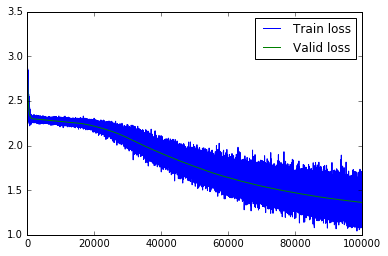

In [13]:
# Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

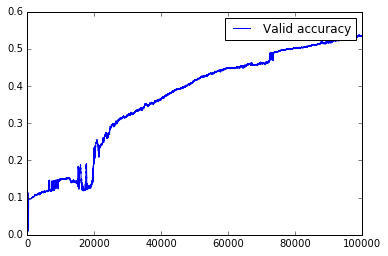

In [14]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()